# Load required packages

In [1]:
## Get dependencies ##

import numpy as np
import string
import math
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sn
from UnFaIR import *
import scipy as sp
import pickle
import time
import scipy as sp
from scipy import ndimage
from scipy import signal
import os
import netCDF4
from difflib import SequenceMatcher
import statsmodels.api as sm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

## Load some colormaps (if needed):

cmap_dirs = [x for x in os.listdir('/home/leachl/Downloads/ScientificColourMaps5/') if not '.' in x and not '+' in x]
cmaps = {}
for cmapname in cmap_dirs:
    cm_data = np.loadtxt('/home/leachl/Downloads/ScientificColourMaps5/'+cmapname+'/'+cmapname+'.txt')
    cmaps[cmapname] = matplotlib.colors.LinearSegmentedColormap.from_list(cmapname, cm_data)

### Import default gas cycle parameters

In [2]:
TUNED_gas_cycle_params = pd.read_pickle('./Parameter_Sets/FaIRv2_gas-cycle-parameters_no-CH4-feedbacks_v1.p')
TUNED_gas_cycle_params_CH4_feedbacks = pd.read_pickle('./Parameter_Sets/FaIRv2_gas-cycle-parameters_incl-CH4-feedbacks_v1.p')
TUNED_thermal_params = pd.read_pickle('./Parameter_Sets/FaIRv2_thermal-cycle-parameters_v1.p')
TUNED_gas_cycle_param_uncertainties = pd.read_pickle('./Parameter_Sets/FaIRv2_thermal-cycle-parameter-uncertainties_v1.p')

## Import the required data

### PRIMAP-hist and GCP emissions

In [3]:
# CO2 from GCP

GCP_CO2_data = pd.read_excel('/home/leachl/Documents/Datasets/Emissions/Global_carbon_budget/Global_Carbon_Budget_2018v1.0.xlsx',-1,skiprows=14,index_col=0)
GCP_CO2_data.iloc[0,:2] = 0
CO2_emms = GCP_CO2_data.interpolate(method='linear').iloc[:,:2].sum(axis=1).rename('CO2')

# CH4 from PRIMAP-hist

PRIMAP_hist=pd.read_csv('/home/leachl/Documents/Datasets/Emissions/PRIMAP-hist/PRIMAP-hist_v2.0_11-Dec-2018/PRIMAP-hist_v2.0_11-Dec-2018.csv')
CH4_emms = PRIMAP_hist.loc[(PRIMAP_hist.country == 'EARTH')&(PRIMAP_hist.scenario=='HISTTP')&(PRIMAP_hist.entity=='CH4')&(PRIMAP_hist.category=='IPCM0EL')].iloc[:,5:].T.apply(pd.to_numeric)
CH4_emms.columns = ['CH4']
CH4_emms = CH4_emms.set_index(np.arange(1850,2017)).reindex(np.arange(1750,2017))
CH4_emms.loc[:1849] = np.linspace(0,0.99,100)[:,np.newaxis] * CH4_emms.loc[1850].values

# N2O from PRIMAP_hist

N2O_emms = PRIMAP_hist.loc[(PRIMAP_hist.country == 'EARTH')&(PRIMAP_hist.scenario=='HISTTP')&(PRIMAP_hist.entity=='N2O')&(PRIMAP_hist.category=='IPCM0EL')].iloc[:,5:].T.apply(pd.to_numeric)
N2O_emms.columns = ['N2O']
N2O_emms = N2O_emms.set_index(np.arange(1850,2017)).reindex(np.arange(1750,2017))
N2O_emms.loc[:1849] = np.linspace(0,0.99,100)[:,np.newaxis] * N2O_emms.loc[1850].values

# Combine
Best_emission_estimates = pd.concat([pd.concat([CO2_emms,CH4_emms/1000,N2O_emms*28/44000],axis=1)],keys=['default'],axis=1)

### CMIP6 historical concentrations plus NOAA extension

In [4]:
#(linearly scaling NOAA to match CMIP6 - not by a lot)

CMIP6_concs = pd.read_csv('/home/leachl/Documents/Datasets/Concentrations/Supplementary_Table_UoM_GHGConcentrations-1-1-0_annualmeans_v23March2017.csv',skiprows=21,index_col=0)
CMIP6_concs_extended = CMIP6_concs.loc[:,['CO2','CH4','N2O']].reindex(np.arange(1500,2019))

NOAA_concs = pd.read_csv('/home/leachl/Documents/Datasets/Concentrations/NOAA_MoleFractions_2019.csv',skiprows=2,index_col=0)
NOAA_concs = NOAA_concs.iloc[1:-5].loc[:,['CO2','CH4','N2O']].apply(pd.to_numeric).set_index(np.arange(1979,2019))

CMIP6_concs_extended.loc[2015:] = NOAA_concs.loc[2015:] * CMIP6_concs.loc[2014,['CO2','CH4','N2O']] / NOAA_concs.loc[2014]

### RCP data

In [5]:
RCP_data = {}
RCP_data['RF'] = {}
RCP_data['C'] = {}
RCP_data['E'] = {}

for RCP in ['3PD','45','6','85']:
    RCP_data['C'][RCP] = pd.read_csv('/home/leachl/Documents/Datasets/RCP_data/RCP'+RCP+'_MIDYEAR_CONCENTRATIONS.csv',skiprows=37,index_col=0).loc[np.arange(1765,2201)]
    RCP_data['RF'][RCP] = pd.read_csv('/home/leachl/Documents/Datasets/RCP_data/RCP'+RCP+'_MIDYEAR_RADFORCING.csv',skiprows=58,index_col=0).loc[np.arange(1765,2201)]
    RCP_data['E'][RCP] = pd.read_csv('/home/leachl/Documents/Datasets/RCP_data/RCP'+RCP+'_EMISSIONS.csv',skiprows=36,index_col=0).loc[:2200]
    RCP_data['E'][RCP]['CO2'] = RCP_data['E'][RCP][['FossilCO2','OtherCO2']].sum(axis=1)

### IAMC scenario database

In [15]:
## Load the IAMC db rfs ## 

#### Import the IAMC database ####

IAMC_db = pd.read_excel('/home/leachl/Documents/Datasets/IIASA_IAMC/iamc15_scenario_data_world_r2.0.xlsx',1)
IAMC_meta = pd.read_excel('/home/leachl/Documents/Datasets/IIASA_IAMC/sr15_metadata_indicators_r2.0.xlsx',1)
data_years = [str(x) for x in range(2000,2101)]

def slice_IAMC_db(Variable=False,Category=False):
    
    ## NB both kwargs must be list types even if slicing only one
    
    if not Category is False:
        
        model_scenario = IAMC_meta.loc[IAMC_meta.category.isin(Category),['model','scenario']].sum(axis=1)
        
        if Variable is False:
            
            return IAMC_db.loc[IAMC_db[['Model','Scenario']].sum(axis=1).isin(model_scenario)]
        
        else:
            
            return IAMC_db.loc[(IAMC_db[['Model','Scenario']].sum(axis=1).isin(model_scenario))&(IAMC_db.Variable.isin(Variable))]
        
    else:
        
        return IAMC_db.loc[IAMC_db.Variable.isin(Variable)]
    
def get_common_model_scenario(dfs):
    
    model_scenario_sets = []
    
    for df in dfs:
        
        model_scenario_sets += [set(df[['Model','Scenario']].sum(axis=1).unique())]
        
    common = set.intersection(*model_scenario_sets)
    
    common_dfs = []
    
    for df in dfs:
        
        common_dfs += [df.loc[df[['Model','Scenario']].sum(axis=1).isin(common)]]
        
    return common_df

# Attributable warming

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.


Integrating 1 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['CO2', 'CH4', 'N2O'], between 1750 and 2019...
Integrating 1 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['CO2', 'CH4', 'N2O'], between 1750 and 2019...


/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


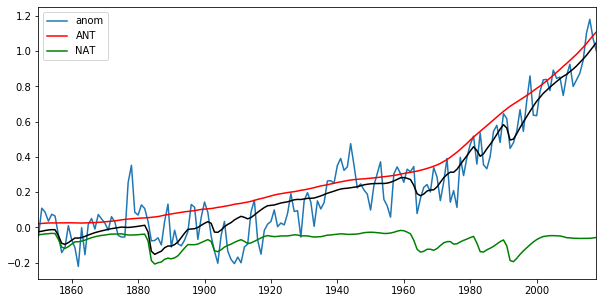

In [6]:
## Get 4 dataset mean temps:

base_fname = '/home/leachl/Documents/Datasets/GMST/HadCRUT.4.6.0.0.monthly_ns_avg_realisations/HadCRUT.4.6.0.0.monthly_ns_avg.'

HadCRUT4_ens_df = pd.DataFrame(index = np.arange(1850+1/12,2019+4/12+0.001,1/12)-1/24,columns = np.arange(1,101))

for i in np.arange(1,101):
    member = str(i)
    fname = base_fname + member + '.txt'
    hadcrut_mem_df = pd.read_csv(fname,sep='   ',header=None)
    temps = hadcrut_mem_df[1].values
    HadCRUT4_ens_df.loc[:,i] = temps
    
temp_base = '/home/leachl/Documents/Datasets/GMST'
CW_temps = pd.read_csv(temp_base+'/CW_had4_krig_v2_0_0.txt',delim_whitespace=True,header=None,index_col=0,names=['Year','anom','tot_uc','cov_uc','ens_uc']).set_index(HadCRUT4_ens_df.index[:-1]).anom
NOAA_temps = pd.read_csv(temp_base+'/NOAA_1880-2019.csv',skiprows=4,index_col=0).set_index(HadCRUT4_ens_df.loc[1880:].index).Value
GISS_temps = pd.read_csv(temp_base+'/nasa_GLB.Ts+dSST.txt',skiprows=7,delim_whitespace=True,index_col=0).iloc[:2019,:12]
GISS_temps = GISS_temps.loc[:'2019'].loc[GISS_temps.loc[:'2019'].index != "Year"].values.flatten()[:-8]
GISS_temps = pd.Series(GISS_temps.astype(float),index = NOAA_temps.index)/100
ALL_temps = pd.DataFrame(index = HadCRUT4_ens_df.index,columns=['anom'])
HC_mem = HadCRUT4_ens_df.median(axis=1)
HC_mem = HC_mem - HC_mem.loc[1850:1900].mean()
CW_mem = CW_temps - CW_temps.loc[1850:1900].mean()
NOAA_mem = NOAA_temps - (NOAA_temps.loc[1880:2017].mean() - HC_mem.loc[1880:2017].mean())
GISS_mem = GISS_temps - (GISS_temps.loc[1880:2017].mean() - HC_mem.loc[1880:2017].mean())
ALL_temps.loc[:,'anom'] = (1/4)*(HC_mem+CW_mem+NOAA_mem+GISS_mem)
ALL_temps.loc[1850:1880,'anom'] = (1/2)*(HC_mem.loc[1850:1880]+CW_mem.loc[1850:1880])
ALL_temps = ALL_temps.loc[:2019]
Annual_4_set_GMST = ALL_temps.rolling(12).mean().iloc[11::12].set_index(np.arange(1850,2019))
                                                                        
fig,ax = plt.subplots(figsize=(10,5))
Annual_4_set_GMST.plot(ax=ax)

HIST_forc_PF = pd.read_csv('/home/leachl/Documents/Datasets/RF/AR5Forcing_ext2015_GHGrevised.txt',skiprows=3,sep='\t',index_col=0).apply(pd.to_numeric)
HIST_forc_PF.iloc[-3:,:] = pd.read_csv('/home/leachl/Documents/Datasets/RF/AR5Forcing_ext2015_GHGrevised.txt',skiprows=271,header=None,delim_whitespace=True,index_col=0).values
HIST_forc_PF = HIST_forc_PF.set_index(np.arange(1750,2020))
HIST_forc_PF['Natural total'] = HIST_forc_PF['Total'] - HIST_forc_PF['Anthro total']

def convert_forc_to_model_input(forcing,scen_name,inner_name='forcing'):
    return pd.concat([pd.DataFrame(forcing.rename(inner_name))],axis=1,keys=[scen_name])

Attr_thermal_params = default_thermal_params()
Attr_thermal_params.loc['tcr_ecs'] = [1.6,2.8]

ANT_temps = run_UnFaIR(emissions_in=return_empty_emissions(convert_forc_to_model_input(HIST_forc_PF['Anthro total'],'Attr_warming')),\
                     forcing_in=convert_forc_to_model_input(HIST_forc_PF['Anthro total'],'Attr_warming'),\
                    thermal_parameters=tcr_ecs_to_q(Attr_thermal_params))['T'].iloc[:,0]

NAT_temps = run_UnFaIR(emissions_in=return_empty_emissions(convert_forc_to_model_input(HIST_forc_PF['Anthro total'],'Attr_warming')),\
                     forcing_in=convert_forc_to_model_input(HIST_forc_PF['Natural total'],'Attr_warming'),\
                    thermal_parameters=tcr_ecs_to_q(Attr_thermal_params))['T'].iloc[:,0]

Y = Annual_4_set_GMST.copy()
X = pd.concat([ANT_temps.rename('ANT'),NAT_temps.rename('NAT')],axis=1)
X = sm.add_constant(X)

regression_model = sm.OLS(Y,X.loc[Y.index])
regression_results = regression_model.fit()
(regression_results.params*X.loc[Y.index])[['ANT','NAT']].plot(ax=ax,color=['r','g'])
(regression_results.params*X.loc[Y.index]).sum(axis=1).plot(ax=ax,color='k')

## Attributable warming:

Attributable_warming = (regression_results.params*X).sum(axis=1) - (regression_results.params*X).sum(axis=1).iloc[0]

# RCP simulations

In [7]:
# Get the RCP data into a format readable by FaIR
RCP_concentration_run = pd.concat([RCP_data['C'][x][['CO2','CH4','N2O']] for x in ['3PD','45','6','85']],keys=['3PD','45','6','85'],axis=1)
RCP_other_forcings_run = pd.concat([RCP_data['RF'][x][['TOTAL_INCLVOLCANIC_RF']].rename({'TOTAL_INCLVOLCANIC_RF':'forcing'},axis=1)-RCP_data['RF'][x][['CO2CH4N2O_RF']].values for x in ['3PD','45','6','85']],keys=['3PD','45','6','85'],axis=1)

# Generate some parameter ensembles uncertainties:

N = 99

# TCR ~ lognorm ; RWF ~ norm
TCR_samples = np.random.lognormal(np.log(2.5)/2,np.log(2.5)/(2*1.645),N)
RWF_samples = np.random.normal(0.6,0.15/1.645,N)
ECS_samples = TCR_samples/RWF_samples

# Put the distributions into a format readable by FaIR
thermal_param_template = default_thermal_params().default
thermal_param_template.loc['tcr_ecs'] = [np.sqrt(2.5),2.66]
thermal_param_list = [thermal_param_template]
for i in np.arange(N):    
    thermal_param_curr = thermal_param_template.copy()
    thermal_param_curr.loc['tcr_ecs'] = [TCR_samples[i],ECS_samples[i]]
    thermal_param_list += [thermal_param_curr]    
thermal_param_set = pd.concat(thermal_param_list,keys=['median']+['set'+str(x) for x in np.arange(N)],axis=1)

# Generate a gas cycle parameter set based on normally distributed parameters
gas_cycle_param_set = draw_monte_carlo_param_set(100,TUNED_gas_cycle_params,TUNED_gas_cycle_param_uncertainties)

# Run the model
# RCP_concentration_driven_results = run_UnFaIR(concentrations_in=RCP_concentration_run,forcing_in=RCP_other_forcings_run,\
#                                   gas_parameters=gas_cycle_param_set,thermal_parameters=tcr_ecs_to_q(thermal_param_set))

## diagnosed emissions from concentrations

/home/leachl/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:969: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


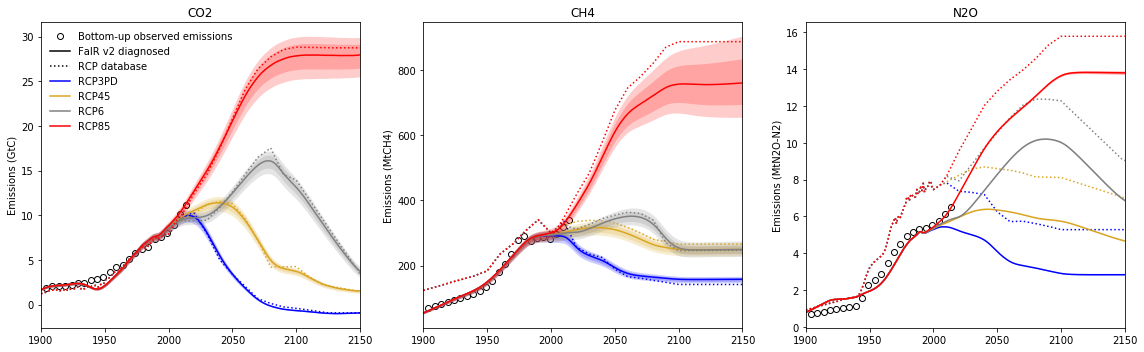

In [33]:
plot_xlim = np.arange(1900,2151)

fig,ax = plt.subplots(1,3,figsize=(16,5))

emms_units = {'CO2':'GtC','CH4':'MtCH4','N2O':'MtN2O-N2'}
emms_source = {'CO2':'GCP','CH4':'PRIMAP-hist','N2O':'PRIMAP-hist'}
RCP_colors = {'3PD':'blue','45':'goldenrod','6':'grey','85':'red'}

for i,gas in enumerate(['CO2','CH4','N2O']):
    
    for RCP in ['3PD','45','6','85']:
    
        emms_to_plot = RCP_concentration_driven_results['Emissions'].xs((RCP,gas),level=(0,3),axis=1).loc[plot_xlim]

        b, a = signal.butter(1, 0.05)

        _83 = signal.filtfilt(b, a, emms_to_plot.quantile(0.83,axis=1))
        _17 = signal.filtfilt(b, a, emms_to_plot.quantile(0.17,axis=1))
        _95 = signal.filtfilt(b, a, emms_to_plot.quantile(0.95,axis=1))
        _05 = signal.filtfilt(b, a, emms_to_plot.quantile(0.05,axis=1))

        ax[i].fill_between(plot_xlim,_83,_17,color=RCP_colors[RCP],alpha=0.2,linewidth=0)
        ax[i].fill_between(plot_xlim,_95,_05,color=RCP_colors[RCP],alpha=0.2,linewidth=0)

        ax[i].plot(plot_xlim,signal.filtfilt(b, a, emms_to_plot['median']['median']),color=RCP_colors[RCP],label='')
        
        ax[i].plot(plot_xlim,RCP_data['E'][RCP][gas].loc[plot_xlim],color=RCP_colors[RCP],linestyle=':',label='')

    ax[i].plot(plot_xlim[4::5],Best_emission_estimates.loc[plot_xlim,('default',gas)].rolling(5,center=True).mean()[4::5],'k',marker='o',mfc='none',lw=0,zorder=0,label='') # rolling mean every 5 years
    
    ax[i].set_xlim(plot_xlim.min(),plot_xlim.max())
    ax[i].set_title(gas)
    ax[i].set_ylabel('Emissions ('+emms_units[gas]+')')
    
# Make the legend
ax[0].plot(0,0,'k',marker='o',mfc='none',lw=0,label='Bottom-up observed emissions')
ax[0].plot(0,0,'k-',label='FaIR v2 diagnosed')
ax[0].plot(0,0,'k:',label='RCP database')
for RCP in ['3PD','45','6','85']:
    ax[0].plot(0,0,color=RCP_colors[RCP],label='RCP'+RCP)
ax[0].legend(frameon=False,loc='upper left')
    
plt.tight_layout()

# fig.suptitle('Emission rate (yr$^{-1}$)',y=1.05,fontsize=15)

# fig.savefig('./Final_figures/RCP concentration driven emissions.svg')

### residual emissions for CH4 and N2O

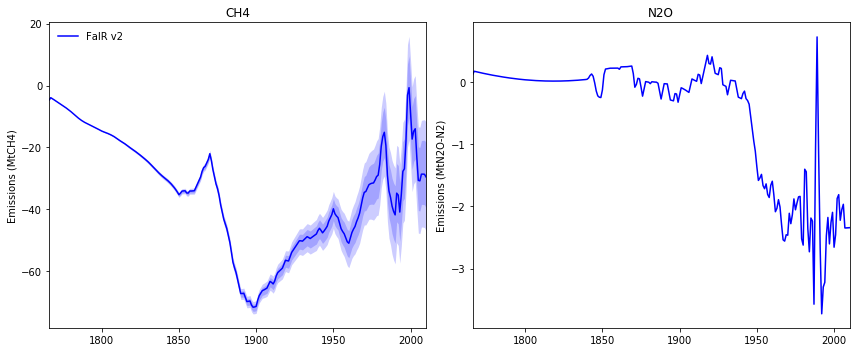

In [10]:
plot_xlim = np.arange(1766,2011)

fig,ax = plt.subplots(1,2,figsize=(12,5))

emms_units = {'CO2':'GtC','CH4':'MtCH4','N2O':'MtN2O-N2'}
emms_source = {'CO2':'GCP','CH4':'PRIMAP-hist','N2O':'PRIMAP-hist'}

RCP='85'

for i,gas in enumerate(['CH4','N2O']):
    
    residual_emissions = RCP_concentration_driven_results['Emissions'].xs((RCP,gas),level=(0,3),axis=1).loc[plot_xlim]-RCP_data['E'][RCP][gas].loc[plot_xlim].values[:,np.newaxis]

    _83 = residual_emissions.quantile(0.83,axis=1)
    _17 = residual_emissions.quantile(0.17,axis=1)
    _95 = residual_emissions.quantile(0.95,axis=1)
    _05 = residual_emissions.quantile(0.05,axis=1)

    ax[i].fill_between(plot_xlim,_83,_17,color='b',alpha=0.2,linewidth=0)
    ax[i].fill_between(plot_xlim,_95,_05,color='b',alpha=0.2,linewidth=0)

    ax[i].plot(plot_xlim,residual_emissions['median']['median'],color='b',label='')
    
    ax[i].set_xlim(plot_xlim.min(),plot_xlim.max())
    ax[i].set_title(gas)
    ax[i].set_ylabel('Emissions ('+emms_units[gas]+')')
    
# Make the legend
ax[0].plot(0,0,'b-',label='FaIR v2')
ax[0].legend(frameon=False,loc='upper left')
    
plt.tight_layout()

# fig.suptitle('Residual emission rate vs RCP database (yr$^{-1}$)',y=1.05,fontsize=15)

# fig.savefig('./Final_figures/RCP concetration driven residual emissions.pdf')

#### MAGICC natural emissions

In [11]:
MAGICC_CH4_nat = pd.read_csv('/home/leachl/Documents/Simple_models/pymagicc_folder/pymagicc/tests/test_data/out_dir/DAT_CH4N_EMIS.OUT',skiprows=23,delim_whitespace=True,index_col=0).apply(pd.to_numeric)
MAGICC_CH4_nat['WORLD'] = MAGICC_CH4_nat.iloc[:,:4].sum(axis=1)

## radiative forcing from concentrations

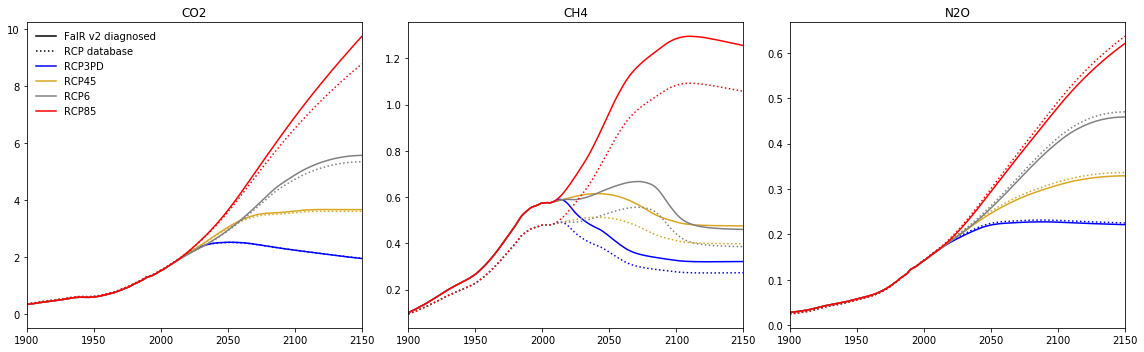

In [12]:
plot_xlim = np.arange(1900,2151)

fig,ax = plt.subplots(1,3,figsize=(16,5))

emms_units = {'CO2':'GtC','CH4':'MtCH4','N2O':'MtN2O-N2'}
emms_source = {'CO2':'GCP','CH4':'PRIMAP-hist','N2O':'PRIMAP-hist'}
RCP_colors = {'3PD':'blue','45':'goldenrod','6':'grey','85':'red'}

for i,gas in enumerate(['CO2','CH4','N2O']):
    
    for RCP in ['3PD','45','6','85']:
    
        RF_to_plot = RCP_concentration_driven_results['RF'].xs((RCP,gas),level=(0,3),axis=1).loc[plot_xlim]

        ax[i].plot(plot_xlim,RF_to_plot['median']['median'],color=RCP_colors[RCP],label='')
        
        ax[i].plot(plot_xlim,RCP_data['RF'][RCP][gas+'_RF'].loc[plot_xlim],color=RCP_colors[RCP],linestyle=':',label='')
    
    ax[i].set_xlim(plot_xlim.min(),plot_xlim.max())
    ax[i].set_title(gas)
    
# Make the legend
ax[0].plot(0,0,'k-',label='FaIR v2 diagnosed')
ax[0].plot(0,0,'k:',label='RCP database')
for RCP in ['3PD','45','6','85']:
    ax[0].plot(0,0,color=RCP_colors[RCP],label='RCP'+RCP)
ax[0].legend(frameon=False,loc='upper left')
    
plt.tight_layout()

# fig.suptitle('Radiative forcing (Wm$^{-2}$)',y=1.05,fontsize=15)

# fig.savefig('./Final_figures/RCP concentration driven RF.svg')

## Temperature from concentrations

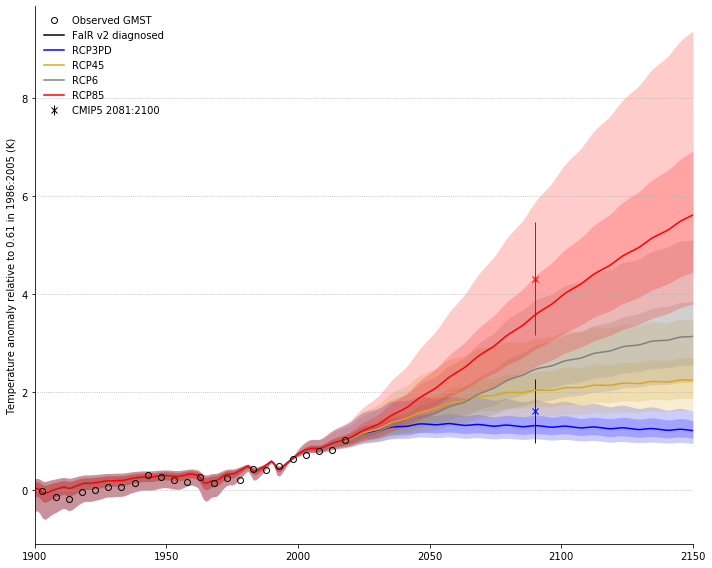

In [13]:
# CMIP5_temps = {}
# CMIP5_temps['3PD'] = pd.read_csv('/home/leachl/Documents/Datasets/CMIP5/Multi-model-mean/icmip5_tas_Amon_modmean_rcp3PD_0-360E_-90-90N_n_000_mean1_anom_30.dat.txt',skiprows=29,delim_whitespace=True,index_col=0,header=None,names=['Year','anom'])
# CMIP5_temps['45'] = pd.read_csv('/home/leachl/Documents/Datasets/CMIP5/Multi-model-mean/icmip5_tas_Amon_modmean_rcp45_0-360E_-90-90N_n_000_mean1_anom_30.dat.txt',skiprows=30,delim_whitespace=True,index_col=0,header=None,names=['Year','anom'])
# CMIP5_temps['6'] = pd.read_csv('/home/leachl/Documents/Datasets/CMIP5/Multi-model-mean/icmip5_tas_Amon_modmean_rcp6_0-360E_-90-90N_n_000_mean1_anom_30.dat.txt',skiprows=29,delim_whitespace=True,index_col=0,header=None,names=['Year','anom'])
# CMIP5_temps['85'] = pd.read_csv('/home/leachl/Documents/Datasets/CMIP5/Multi-model-mean/icmip5_tas_Amon_modmean_rcp85_0-360E_-90-90N_n_000_mean1_anom_30.dat.txt',skiprows=30,delim_whitespace=True,index_col=0,header=None,names=['Year','anom'])

CMIP5_2100_ranges = {}
CMIP5_2100_ranges['3PD'] = pd.Series([1,0.4,0.4*1.645],index=['MED','83','95'])
CMIP5_2100_ranges['45'] = pd.Series([1.8,0.5,0.5*1.645],index=['MED','83','95'])
CMIP5_2100_ranges['6'] = pd.Series([2.2,0.5,0.5*1.645],index=['MED','83','95'])
CMIP5_2100_ranges['85'] = pd.Series([3.7,0.7,0.7*1.645],index=['MED','83','95'])

plot_xlim = np.arange(1900,2151)

fig,ax = plt.subplots(figsize=(10,8))

RCP_colors = {'3PD':'blue','45':'goldenrod','6':'grey','85':'red'}

for RCP in ['3PD','45','6','85']:

    temp_to_plot = (RCP_concentration_driven_results['T'].xs((RCP),level=(0),axis=1)-RCP_concentration_driven_results['T'].xs((RCP),level=(0),axis=1).loc[1986:2005].mean()).loc[plot_xlim] + 0.61

    b, a = signal.butter(1, 0.05)

    _83 = temp_to_plot.quantile(0.83,axis=1)
    _17 = temp_to_plot.quantile(0.17,axis=1)
    _95 = temp_to_plot.quantile(0.95,axis=1)
    _05 = temp_to_plot.quantile(0.05,axis=1)

    ax.fill_between(plot_xlim,_83,_17,color=RCP_colors[RCP],alpha=0.2,linewidth=0)
    ax.fill_between(plot_xlim,_95,_05,color=RCP_colors[RCP],alpha=0.2,linewidth=0)

    ax.plot(plot_xlim,temp_to_plot['median']['median'],color=RCP_colors[RCP],label='')
    
    if RCP in ['3PD','85']:
    
        ax.errorbar(2090,CMIP5_2100_ranges[RCP].loc['MED']+0.61,yerr=CMIP5_2100_ranges[RCP].loc['95'],fmt='x',color=RCP_colors[RCP],lw=1)

ax.plot((Annual_4_set_GMST-Annual_4_set_GMST.loc[1986:2005].mean()+0.61).rolling(5).mean().iloc[3::5],'k',marker='o',mfc='none',lw=0,label='Observed GMST')

ax.set_xlim(plot_xlim.min(),plot_xlim.max())
ax.set_title('')
ax.set_ylabel('Temperature anomaly relative to 0.61 in 1986:2005 (K)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis='y',linestyle=':',zorder=0)

# Make the legend
ax.plot(0,0,'k-',label='FaIR v2 diagnosed')
ax.errorbar(0,0,yerr=0.5,fmt='x',color='k',label='CMIP5 2081:2100',lw=1)
for RCP in ['3PD','45','6','85']:
    ax.plot(0,0,color=RCP_colors[RCP],label='RCP'+RCP)
ax.legend(frameon=False,loc='upper left')

    
plt.tight_layout()

# fig.suptitle('Emission rate (yr$^{-1}$)',y=1.05,fontsize=15)

# fig.savefig('./Final_figures/RCP concentration driven temperatures.svg')

### Alternate runs with Tsutsui consistent observational tas-only TCR and ECS

In [14]:
N=99

# TCR ~ lognorm ; RWF ~ norm
TCR_samples = np.random.normal(1.81,0.6/1.645,N)
RWF_samples = np.random.normal(0.6,0.15/1.645,N)
ECS_samples = TCR_samples/RWF_samples

# Put the distributions into a format readable by FaIR
thermal_param_template = default_thermal_params().default
thermal_param_template.loc['tcr_ecs'] = [1.81,3.1]
thermal_param_template.loc['d'] = [222,3.59]
thermal_param_list = [thermal_param_template]
for i in np.arange(N):    
    thermal_param_curr = thermal_param_template.copy()
    thermal_param_curr.loc['tcr_ecs'] = [TCR_samples[i],ECS_samples[i]]
    thermal_param_list += [thermal_param_curr]    
thermal_param_set_alternate = pd.concat(thermal_param_list,keys=['median']+['set'+str(x) for x in np.arange(N)],axis=1)

# Run the model
RCP_concentration_driven_results_alternate_TCR = run_UnFaIR(concentrations_in=RCP_concentration_run,forcing_in=RCP_other_forcings_run,\
                                  gas_parameters=gas_cycle_param_set,thermal_parameters=tcr_ecs_to_q(thermal_param_set_alternate,F_2x=3.44))

Integrating 4 scenarios, 100 gas cycle parameter sets, 100 thermal response parameter sets, over ['CO2', 'CH4', 'N2O'], between 1765 and 2200...


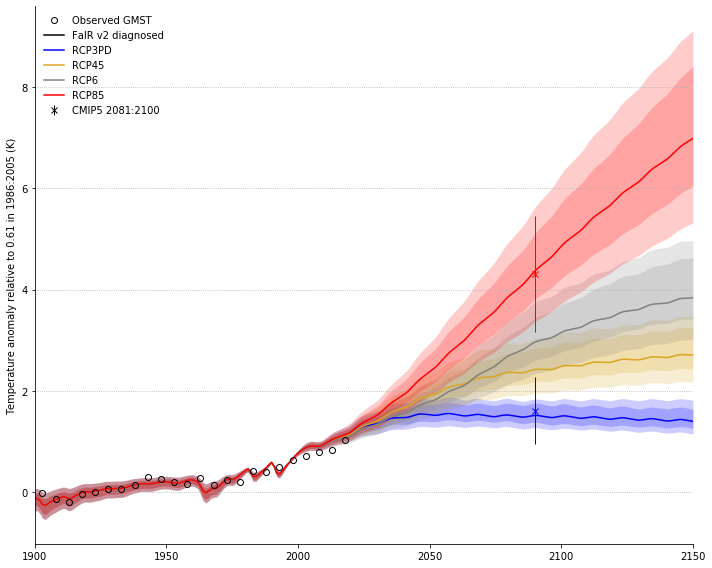

In [15]:
plot_xlim = np.arange(1900,2151)

fig,ax = plt.subplots(figsize=(10,8))

RCP_colors = {'3PD':'blue','45':'goldenrod','6':'grey','85':'red'}

for RCP in ['3PD','45','6','85']:

    temp_to_plot = (RCP_concentration_driven_results_alternate_TCR['T'].xs((RCP),level=(0),axis=1)-RCP_concentration_driven_results_alternate_TCR['T'].xs((RCP),level=(0),axis=1).loc[1986:2005].mean()).loc[plot_xlim] + 0.61

    b, a = signal.butter(1, 0.05)

    _83 = temp_to_plot.quantile(0.83,axis=1)
    _17 = temp_to_plot.quantile(0.17,axis=1)
    _95 = temp_to_plot.quantile(0.95,axis=1)
    _05 = temp_to_plot.quantile(0.05,axis=1)

    ax.fill_between(plot_xlim,_83,_17,color=RCP_colors[RCP],alpha=0.2,linewidth=0)
    ax.fill_between(plot_xlim,_95,_05,color=RCP_colors[RCP],alpha=0.2,linewidth=0)

    ax.plot(plot_xlim,temp_to_plot['median']['median'],color=RCP_colors[RCP],label='')
    
    if RCP in ['3PD','85']:
    
        ax.errorbar(2090,CMIP5_2100_ranges[RCP].loc['MED']+0.61,yerr=CMIP5_2100_ranges[RCP].loc['95'],fmt='x',color=RCP_colors[RCP],lw=1)

ax.plot((Annual_4_set_GMST-Annual_4_set_GMST.loc[1986:2005].mean()+0.61).rolling(5).mean().iloc[3::5],'k',marker='o',mfc='none',lw=0,label='Observed GMST')

ax.set_xlim(plot_xlim.min(),plot_xlim.max())
ax.set_title('')
ax.set_ylabel('Temperature anomaly relative to 0.61 in 1986:2005 (K)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis='y',linestyle=':',zorder=0)

# Make the legend
ax.plot(0,0,'k-',label='FaIR v2 diagnosed')
ax.errorbar(0,0,yerr=0.5,fmt='x',color='k',label='CMIP5 2081:2100',lw=1)
for RCP in ['3PD','45','6','85']:
    ax.plot(0,0,color=RCP_colors[RCP],label='RCP'+RCP)
ax.legend(frameon=False,loc='upper left')

    
plt.tight_layout()

# fig.suptitle('Emission rate (yr$^{-1}$)',y=1.05,fontsize=15)

# fig.savefig('./Final_figures/RCP concentration driven temperatures alternate TCR.svg')

## concentrations from emissions

In [16]:
## Import other estimates of concentrations from RCP simulations:

Prather_2012_GRL = {}
Prather_2012_GRL['CH4'] = {}
Prather_2012_GRL['N2O'] = {}

for i,RCP in enumerate(['3PD','45','6','85']):
    Prather_2012_GRL['N2O'][RCP] = pd.read_csv('/home/leachl/Downloads/Reactive_GHG_scenarios_supp/grl29135-sup-0008-sfts01/2012GL051440_matlab/output_mc100000.txt',skiprows=19+21*i,nrows=10,delim_whitespace=True,usecols=[0,1,3,4,6,7,9,10,12,13,15],\
            header=None,names=['Year','Emission(Tg/a)','unc','Abundance(ppb)','unc','RF(W/m2)','unc','T_OH(a)','unc','T_total(a)','unc'],index_col=0).apply(pd.to_numeric)
    Prather_2012_GRL['CH4'][RCP] = pd.read_csv('/home/leachl/Downloads/Reactive_GHG_scenarios_supp/grl29135-sup-0008-sfts01/2012GL051440_matlab/output_mc100000.txt',skiprows=107+21*i,nrows=10,delim_whitespace=True,usecols=[0,1,3,4,6,7,9,10,12,13,15],\
            header=None,names=['Year','Emission(Tg/a)','unc','Abundance(ppb)','unc','RF(W/m2)','unc','T_OH(a)','unc','T_total(a)','unc'],index_col=0).apply(pd.to_numeric)

/home/leachl/miniconda3/lib/python3.7/site-packages/pandas/io/parsers.py:702: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


In [17]:
# Get the RCP data into a format readable by FaIR
RCP_emissions_run = pd.concat([RCP_data['E'][x][['CO2','CH4','N2O']] for x in ['3PD','45','6','85']],keys=['3PD','45','6','85'],axis=1)

# Run the model
RCP_emission_driven_results = run_UnFaIR(emissions_in=RCP_emissions_run,forcing_in=RCP_other_forcings_run,\
                                  gas_parameters=gas_cycle_param_set,thermal_parameters=tcr_ecs_to_q(thermal_param_set))

Integrating 4 scenarios, 100 gas cycle parameter sets, 100 thermal response parameter sets, over ['CO2', 'CH4', 'N2O'], between 1765 and 2200...


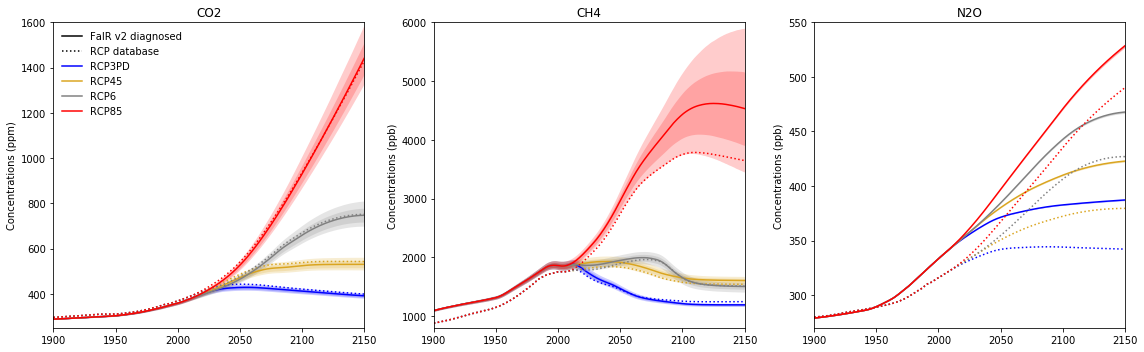

In [18]:
plot_xlim = np.arange(1900,2151)

fig,ax = plt.subplots(1,3,figsize=(16,5))

conc_units = {'CO2':'ppm','CH4':'ppb','N2O':'ppb'}
RCP_colors = {'3PD':'blue','45':'goldenrod','6':'grey','85':'red'}

for i,gas in enumerate(['CO2','CH4','N2O']):
    
    for RCP in ['3PD','45','6','85']:
    
        concs_to_plot = RCP_emission_driven_results['C'].xs((RCP,gas),level=(0,3),axis=1).loc[plot_xlim]

        _83 = concs_to_plot.quantile(0.83,axis=1)
        _17 = concs_to_plot.quantile(0.17,axis=1)
        _95 = concs_to_plot.quantile(0.95,axis=1)
        _05 = concs_to_plot.quantile(0.05,axis=1)
        
        _95_therm = concs_to_plot.xs('median',level=1,axis=1).quantile(0.95,axis=1)
        _05_therm = concs_to_plot.xs('median',level=1,axis=1).quantile(0.05,axis=1)

        ax[i].fill_between(plot_xlim,_17,_83,color=RCP_colors[RCP],alpha=0.2,linewidth=0)
        ax[i].fill_between(plot_xlim,_95,_05,color=RCP_colors[RCP],alpha=0.2,linewidth=0)

        ax[i].plot(plot_xlim,concs_to_plot['median']['median'],color=RCP_colors[RCP],label='')
        
        ax[i].plot(plot_xlim,RCP_data['C'][RCP][gas].loc[plot_xlim],color=RCP_colors[RCP],linestyle=':',label='')
        
#         if gas in ['CH4','N2O']:
            
#             ax[i].errorbar(2050,Prather_2012_GRL[gas][RCP].loc[2050,'Abundance(ppb)'],Prather_2012_GRL[gas][RCP].loc[2050,'unc.1'],color=RCP_colors[RCP])
#             ax[i].errorbar(2100,Prather_2012_GRL[gas][RCP].loc[2100,'Abundance(ppb)'],Prather_2012_GRL[gas][RCP].loc[2100,'unc.1'],color=RCP_colors[RCP])
    
    ax[i].set_xlim(plot_xlim.min(),plot_xlim.max())
    ax[i].set_title(gas)
    ax[i].set_ylabel('Concentrations ('+conc_units[gas]+')')
    
# Make the legend
ax[0].plot(0,0,'k-',label='FaIR v2 diagnosed')
ax[0].plot(0,0,'k:',label='RCP database')
for RCP in ['3PD','45','6','85']:
    ax[0].plot(0,0,color=RCP_colors[RCP],label='RCP'+RCP)
ax[0].legend(frameon=False,loc='upper left')
    
ax[0].set_ylim(250,1600)
ax[1].set_ylim(800,6000)
ax[2].set_ylim(270,550)
    
plt.tight_layout()

# fig.suptitle('Emission driven concentrations',y=1.05,fontsize=15)

# fig.savefig('./Final_figures/RCP emission driven concentrations.pdf')

# Default parameter SSP (baseline/marker) scenario runs

In [8]:
Inv_emms_CMIP6_concs_run = pd.concat([CMIP6_concs_extended.loc[1750:]],keys=['Observed_run'],axis=1)

CMIP6_concs_run_RF = run_UnFaIR(concentrations_in=Inv_emms_CMIP6_concs_run,gas_parameters=TUNED_gas_cycle_params,thermal_parameters=tcr_ecs_to_q(TUNED_thermal_params),show_run_info=False)['RF'].xs('Total',level=-1,axis=1).values.flatten()

Inv_emms_other_forc_run = pd.concat([pd.DataFrame((HIST_forc_PF.loc[:2018,'Total'] - CMIP6_concs_run_RF).rename('forcing'))],keys=['Observed_run'],axis=1)

Inv_emms_run = run_UnFaIR(concentrations_in=Inv_emms_CMIP6_concs_run,forcing_in=Inv_emms_other_forc_run,gas_parameters=TUNED_gas_cycle_params,thermal_parameters=tcr_ecs_to_q(TUNED_thermal_params),show_run_info=False)

Inv_emms_observed = Inv_emms_run['Emissions'].xs(('Observed_run','default','default'),level=(0,1,2),axis=1)

other_forc_observed = Inv_emms_other_forc_run['Observed_run']

In [20]:
# first a function to harmonize the SSP emission scenarios with those derived from CMIP6 observed concentration runs

def harmonize_scenario_emissions(scenario,IAM,smooth_history=False,join_year=2005,matched_year=2025):
    
    scenario_emissions = IAMC_db.loc[(IAMC_db.Variable.isin(['Diagnostics|MAGICC6|Harmonized Input|Emissions|'+x for x in ['CH4','N2O','CO2|AFOLU','CO2|Energy and Industrial Processes']]))&(IAMC_db.Scenario==scenario)&(IAMC_db.Model==IAM)]
    scenario_emissions = scenario_emissions.iloc[:,5:].apply(pd.to_numeric).interpolate(axis=1)#.set_index(['CH4','CO2-AFOLU','CO2-EIP','N2O'])
    scenario_emissions.index = ['CH4','CO2-AFOLU','CO2-EIP','N2O']
    scenario_emissions.loc['CO2'] = scenario_emissions.loc[['CO2-AFOLU','CO2-EIP']].sum()
    scenario_emissions = scenario_emissions.T[['CO2','CH4','N2O']]
    scenario_emissions = (scenario_emissions * [12/44000,1,28/44000]).dropna().set_index(np.arange(2005,2101))
    
    # harmonize emissions to inverted RCP85 concentrations
    
    Observational_diagnosed_emms = Inv_emms_observed.copy()

    if smooth_history:
    
        b, a = signal.butter(1, 0.05)
        for gas in ['CO2','CH4','N2O']:
            Observational_diagnosed_emms[gas] = signal.filtfilt(b, a, Observational_diagnosed_emms[gas])

    harmonized_emissions = Observational_diagnosed_emms.reindex(np.concatenate((Observational_diagnosed_emms.index.values,np.arange(Observational_diagnosed_emms.index[-1]+1,2101))))
    
    for gas in ['CO2','CH4','N2O']:
        harmonized_emissions.loc[join_year:matched_year,gas] = scenario_emissions.loc[join_year:matched_year,gas] * np.linspace(harmonized_emissions.loc[join_year,gas]/scenario_emissions.loc[join_year,gas],1,matched_year-join_year+1)
        
    harmonized_emissions.loc[2025:] = scenario_emissions.loc[2025:]

    return harmonized_emissions

# next a function to harmonize the forcing to the estimated historical other forcing

def harmonize_scenario_forcing(scenario,IAM,smooth_history=False,join_year=2005,matched_year=2025):
    
    scenario_forcings = IAMC_db.loc[(IAMC_db.Variable.isin(['AR5 climate diagnostics|Forcing'+x+'|MAGICC6|MED' for x in ['|CH4','|N2O','|CO2','']]))&(IAMC_db.Scenario==scenario)&(IAMC_db.Model==IAM)]
    scenario_forcings= scenario_forcings.iloc[:,5:].apply(pd.to_numeric)
    scenario_forcings.index = ['CH4','CO2','Total','N2O']
    scenario_forcings = scenario_forcings.T
    scenario_forcings['forcing'] = scenario_forcings['Total'] - scenario_forcings[['CO2','CH4','N2O']].sum(axis=1)
    scenario_forcings = scenario_forcings.set_index(np.arange(2000,2101))
    
    harmonized_forcing = other_forc_observed.copy().reindex(np.concatenate((other_forc_observed.index.values,np.arange(other_forc_observed.index[-1]+1,2101))))
    
    # harmonize forcings to Forster method best-estimate
    
    harmonized_forcing.loc[join_year:matched_year,'forcing'] = scenario_forcings.loc[join_year:matched_year,'forcing'] * np.linspace(harmonized_forcing.loc[join_year,'forcing']/scenario_forcings.loc[join_year,'forcing'],1,matched_year-join_year+1)
    harmonized_forcing.loc[matched_year:,'forcing'] = scenario_forcings.loc[matched_year:,'forcing']
    
    return harmonized_forcing

In [21]:
IMAGE_scenarios = IAMC_db.loc[(IAMC_db.Scenario.isin(list(set([x for x in IAMC_db.Scenario if x[:3] == 'SSP']))))&(IAMC_db.Model=='IMAGE 3.0.1')].Scenario.unique()

SSP_emms_list = []
SSP_forc_list = []

for scenario in IMAGE_scenarios:
    
    SSP_emms_list += [harmonize_scenario_emissions(scenario,'IMAGE 3.0.1',False,2015,2025)]
    SSP_forc_list += [harmonize_scenario_forcing(scenario,'IMAGE 3.0.1',False,2015,2025)]
    
SSP_emms_run = pd.concat(SSP_emms_list,keys=IMAGE_scenarios,axis=1)
SSP_forc_run = pd.concat(SSP_forc_list,keys=IMAGE_scenarios,axis=1)
start_time = time.time()
SSP_baseline_run = run_UnFaIR(emissions_in=SSP_emms_run,forcing_in=SSP_forc_run,thermal_parameters=tcr_ecs_to_q(thermal_param_set),gas_parameters=gas_cycle_param_set)
print(time.time()-start_time)

Integrating 23 scenarios, 100 gas cycle parameter sets, 100 thermal response parameter sets, over ['CO2', 'CH4', 'N2O'], between 1750 and 2100...
95.90393567085266


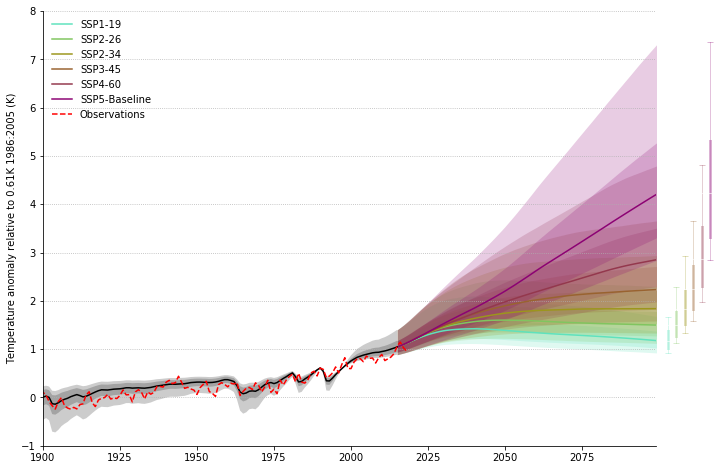

In [22]:
plot_xlim = np.arange(1900,2100)

gs = matplotlib.gridspec.GridSpec(1, 12)
fig = plt.figure(figsize=(12,8))
ax = plt.subplot(gs[0, :-1])
ax1 = plt.subplot(gs[0, -1])

scenarios_to_plot = np.array(['SSP1-19','SSP2-26','SSP2-34','SSP3-45','SSP4-60','SSP5-Baseline'])

scenario_colors = cmaps['hawaii']((1/scenarios_to_plot.size)*np.arange(scenarios_to_plot.size))[::-1]
    
for i,scenario in enumerate(scenarios_to_plot):

    temp_to_plot = (SSP_baseline_run['T'].xs((scenario),level=(0),axis=1)-SSP_baseline_run['T'].xs((scenario),level=(0),axis=1).loc[1986:2005].mean()+0.61).loc[2015:]

    _83 = temp_to_plot.quantile(0.83,axis=1)
    _17 = temp_to_plot.quantile(0.17,axis=1)
    _95 = temp_to_plot.quantile(0.95,axis=1)
    _05 = temp_to_plot.quantile(0.05,axis=1)
    
    _95_therm = temp_to_plot.xs('median',level=1,axis=1).quantile(0.95,axis=1)
    _05_therm = temp_to_plot.xs('median',level=1,axis=1).quantile(0.05,axis=1)

    ax.fill_between(np.arange(2015,2101),_83,_17,color=scenario_colors[i],alpha=0.2,linewidth=0)
    ax.fill_between(np.arange(2015,2101),_95,_05,color=scenario_colors[i],alpha=0.2,linewidth=0)

    ax.plot(np.arange(2015,2101),temp_to_plot['median']['median'],color=scenario_colors[i],label=scenario)
    
    ax1.plot([i,i],[_17.loc[2100],_83.loc[2100]],color=scenario_colors[i],linewidth=3,alpha=0.3)
    ax1.plot([i,i],[_05.loc[2100],_95.loc[2100]],color=scenario_colors[i],linewidth=0.8,alpha=0.3)
    ax1.plot([i,i],[_05.loc[2100],_95.loc[2100]],color=scenario_colors[i],marker='_',linewidth=0,alpha=0.3)
    ax1.plot([i],[temp_to_plot['median']['median'].loc[2100]],'white',marker='_',linewidth=0,alpha=0.6,ms=20)
    
temp_to_plot = (SSP_baseline_run['T'].xs((scenario),level=(0),axis=1)-SSP_baseline_run['T'].xs((scenario),level=(0),axis=1).loc[1986:2005].mean()+0.61).loc[:2015]

_83 = temp_to_plot.quantile(0.83,axis=1)
_17 = temp_to_plot.quantile(0.17,axis=1)
_95 = temp_to_plot.quantile(0.95,axis=1)
_05 = temp_to_plot.quantile(0.05,axis=1)

ax.fill_between(np.arange(1750,2016),_83,_17,color='k',alpha=0.2,linewidth=0)
ax.fill_between(np.arange(1750,2016),_95,_05,color='k',alpha=0.2,linewidth=0)

ax.plot(np.arange(1750,2016),temp_to_plot['median']['median'],color='k',label='')
    
ax.plot((Annual_4_set_GMST-Annual_4_set_GMST.loc[1986:2005].mean()+0.61),'r--',label='Observations')

ax.set_xlim(plot_xlim.min(),plot_xlim.max())
# ax.set_title('FaIR v2.0 probabilistic response')
ax.set_ylabel('Temperature anomaly relative to 0.61K 1986:2005 (K)')
ax.set_ylim(-1,8)
ax1.set_ylim(-1,8)
ax1.axis('off')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis='y',linestyle=':',zorder=0)

fig.subplots_adjust(wspace=0.2)
    
# Make the legend

ax.legend(frameon=False,loc='upper left')

# fig.savefig('./Final_figures/FaIRv2 harmonized SSP default probabilistic temperature response.pdf',bbox_inches='tight')

## CMIP6 parameter SSP run

In [23]:
## Do I do some IAMC scenarios with GenIR tuned to different CMIP6 models now - to show only one model really necessary given it is sufficiently tunable?? ##

JT_params = pd.read_csv('./J_Tsutsui_params/2019-07-17_1954/parms_cmip6_20190716.csv')

JT_params = JT_params.loc[(JT_params.iloc[:,1] == 'tas')&((JT_params.iloc[:,2] == 'irm-2')|(JT_params.iloc[:,2] == 'irm-3'))]

JT_UnFaIR_params = pd.DataFrame(columns=[1,2,3],index=['d','q'])

JT_UnFaIR_params.index = JT_UnFaIR_params.index.rename('param_name')

JT_UnFaIR_params.columns = JT_UnFaIR_params.columns.rename('Box')

param_list = []

for i in JT_params.index:

    curr_params = JT_UnFaIR_params.copy()
    
    curr_params.loc['d'] = (JT_params.loc[i,'tau0':'tau2']).values
    
    curr_params.loc['q'] = (JT_params.loc[i,'a0':'a2'] / JT_params.loc[i,'lambda']).values
    
    param_list += [curr_params]
    
JT_UnFaIR_params = pd.concat(param_list, keys = JT_params.iloc[:,0]+'_'+JT_params.iloc[:,2], axis = 1)

JT_UnFaIR_params.columns = JT_UnFaIR_params.columns.rename(['CMIP6-model_IR(n)','Box'])

JT_UnFaIR_params = JT_UnFaIR_params.apply(pd.to_numeric)

JT_UnFaIR_params.loc['d',([x for x in JT_UnFaIR_params.columns.levels[0] if 'irm-2' in x],3)] = 1.
JT_UnFaIR_params.loc['q',([x for x in JT_UnFaIR_params.columns.levels[0] if 'irm-2' in x],3)] = 0

In [24]:
SSP_CMIP6_models = [x for x in JT_UnFaIR_params.columns.levels[0] if '_irm-2' in x]

f_params_CMIP6 = pd.read_pickle('./Parameter_Sets/CMIP6_f_parameters.p')

SSP_CMIP6_results = []

for CMIP6_model in SSP_CMIP6_models:
    
    CMIP6_thermal_params_run = JT_UnFaIR_params[[CMIP6_model]]
    
    CMIP6_gas_cycle_params_run = TUNED_gas_cycle_params.copy()
    
    CMIP6_gas_cycle_params_run.loc['f1':'f3',('default','CO2')] = f_params_CMIP6[CMIP6_model]

    SSP_CMIP6_results += [run_UnFaIR(emissions_in=SSP_emms_run,forcing_in=SSP_forc_run,thermal_parameters=CMIP6_thermal_params_run,gas_parameters=CMIP6_gas_cycle_params_run,show_run_info=False)['T']]
    
SSP_CMIP6_results = pd.concat(SSP_CMIP6_results,keys=[x[:-6] for x in SSP_CMIP6_models],axis=1).droplevel(-1,1)

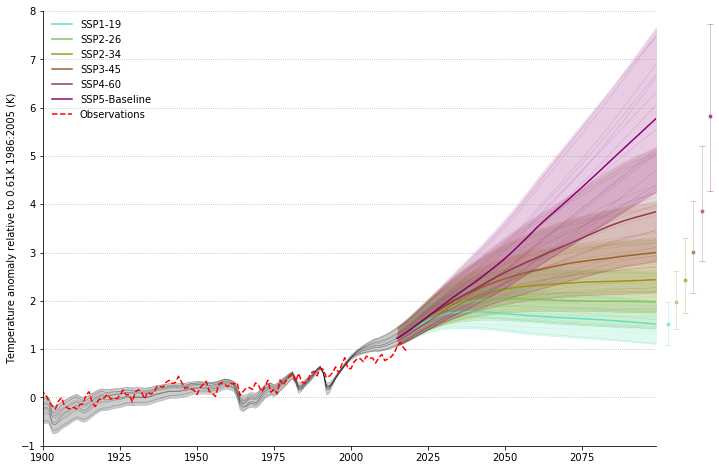

In [25]:
plot_xlim = np.arange(1900,2100)

gs = matplotlib.gridspec.GridSpec(1, 12)
fig = plt.figure(figsize=(12,8))
ax = plt.subplot(gs[0, :-1])
ax1 = plt.subplot(gs[0, -1])

scenarios_to_plot = np.array(['SSP1-19','SSP2-26','SSP2-34','SSP3-45','SSP4-60','SSP5-Baseline'])

scenario_colors = cmaps['hawaii']((1/scenarios_to_plot.size)*np.arange(scenarios_to_plot.size))[::-1]
    
for i,scenario in enumerate(scenarios_to_plot):

    temp_to_plot = (SSP_CMIP6_results.xs((scenario),level=(1),axis=1)-SSP_CMIP6_results.xs((scenario),level=(1),axis=1).loc[1986:2005].mean()+0.61).loc[2015:]

    ax.fill_between(np.arange(2015,2101),temp_to_plot.max(axis=1),temp_to_plot.min(axis=1),color=scenario_colors[i],alpha=0.2,linewidth=0,label='')
    
    ax.plot(temp_to_plot.median(axis=1),color=scenario_colors[i],label=scenario)
    
    ax.plot(temp_to_plot,color=scenario_colors[i],label='',linewidth=0.1)
    
    ax1.plot([i,i],[temp_to_plot.loc[2100].min(),temp_to_plot.loc[2100].max()],color=scenario_colors[i],linewidth=0.8,alpha=0.3)
    ax1.plot([i,i],[temp_to_plot.loc[2100].min(),temp_to_plot.loc[2100].max()],color=scenario_colors[i],marker='_',linewidth=0,alpha=0.3)
    ax1.plot([i],[temp_to_plot.loc[2100].median()],color=scenario_colors[i],marker='o',linewidth=0,alpha=0.6,ms=3)
    
temp_to_plot = (SSP_CMIP6_results.xs((scenario),level=(1),axis=1)-SSP_CMIP6_results.xs((scenario),level=(1),axis=1).loc[1986:2005].mean()+0.61).loc[:2015]

ax.plot(np.arange(1750,2016),temp_to_plot,color='k',linewidth=0.1,label='')

ax.fill_between(np.arange(1750,2016),temp_to_plot.max(axis=1),temp_to_plot.min(axis=1),color='k',linewidth=0,alpha=0.2,label='')
    
ax.plot((Annual_4_set_GMST-Annual_4_set_GMST.loc[1986:2005].mean()+0.61),'r--',label='Observations')

ax.set_xlim(plot_xlim.min(),plot_xlim.max())
# ax.set_title('FaIR v2.0 probabilistic response')
ax.set_ylabel('Temperature anomaly relative to 0.61K 1986:2005 (K)')
ax.set_ylim(-1,8)
ax1.set_ylim(-1,8)
ax1.axis('off')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis='y',linestyle=':',zorder=0)

fig.subplots_adjust(wspace=0.2)
    
# Make the legend

ax.legend(frameon=False,loc='upper left')

# fig.savefig('./Final_figures/FaIRv2 harmonized SSP CMIP6 temperature response.svg',bbox_inches='tight')

### Comparing FaIR v1.3 and MAGICC - global temperatures plus forcings

#### Can we tune the FaIR v2.0 response to MAGICC6?

In [26]:
SSP_MAGICC_forc = SSP_baseline_run['RF'].loc[:,(scenarios_to_plot,'median','median','Total')].droplevel((1,2),1)
SSP_MAGICC_forc = pd.concat([pd.DataFrame(index=SSP_MAGICC_forc.index,columns=['forcing'])]*6,keys=scenarios_to_plot,axis=1).fillna(0) + SSP_MAGICC_forc.values
for scenario in scenarios_to_plot:
    
    SSP_MAGICC_forc.loc[2005:,(scenario,'forcing')] = IAMC_db.loc[(IAMC_db.Variable=='AR5 climate diagnostics|Forcing|MAGICC6|MED')&(IAMC_db.Scenario==scenario)&(IAMC_db.Model=='IMAGE 3.0.1')].iloc[:,5:].apply(pd.to_numeric).T.set_index(np.arange(2000,2101)).loc[2005:].values.flatten()
    
def tune_to_MAGICC(x):
    
    tune_thermal_params = TUNED_thermal_params.copy()
    
#     tune_thermal_params.loc['d'] = x[:2]
    tune_thermal_params.loc['tcr_ecs'] = x
    
    tuning_run = run_UnFaIR(emissions_in=return_empty_emissions(SSP_MAGICC_forc),forcing_in=SSP_MAGICC_forc,thermal_parameters=tcr_ecs_to_q(tune_thermal_params),show_run_info=False)['T']
    
    cost_func = 0
    
    for scenario in scenarios_to_plot:
    
        MAGICC_temps = IAMC_db.loc[(IAMC_db.Variable=='AR5 climate diagnostics|Temperature|Global Mean|MAGICC6|MED')&(IAMC_db.Scenario==scenario)&(IAMC_db.Model=='IMAGE 3.0.1')].iloc[:,5:].apply(pd.to_numeric).T.set_index(np.arange(2000,2101)).loc[2010:]
        
        cost_func += np.sum(((MAGICC_temps-MAGICC_temps.loc[2010]).values - (tuning_run-tuning_run.loc[2010]).loc[2010:,scenario].values)**2)
    
    return cost_func

# print(sp.optimize.minimize(tune_to_MAGICC,x0=[2,3],method='Nelder-mead'))

print('Results:')
print('TCR = 2.07 for TCR/ECS = 0.6')
print('TCR = 2.01, ECS = 3.72 for unconstrained RWF, least squares = 1.46 K over 90 years * 6 scenarios')

Results:
TCR = 2.07 for TCR/ECS = 0.6
TCR = 2.01, ECS = 3.72 for unconstrained RWF, least squares = 1.46 K over 90 years * 6 scenarios


In [27]:
# Run the SSPs through with MAGICC-like thermal parameters:

MAGICC_thermal_params = TUNED_thermal_params.copy()
MAGICC_thermal_params.loc['tcr_ecs'] = [2.11,3.72]

MAGICC_like_SSP_run = run_UnFaIR(emissions_in=SSP_emms_run,forcing_in=SSP_forc_run,thermal_parameters=tcr_ecs_to_q(MAGICC_thermal_params),gas_parameters=TUNED_gas_cycle_params)

Integrating 23 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['CO2', 'CH4', 'N2O'], between 1750 and 2100...


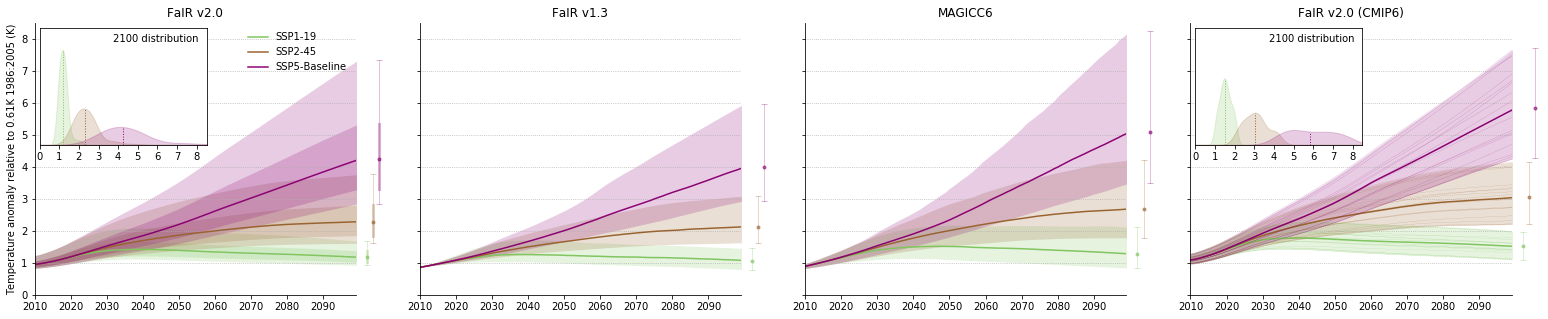

In [28]:
##### Full temperature range comparison:

plot_xlim = np.arange(2010,2100)

gs = matplotlib.gridspec.GridSpec(1, 51)
fig = plt.figure(figsize=(27,5))
ax = plt.subplot(gs[0, :11])
ax1 = plt.subplot(gs[0, 11])
ax2 = plt.subplot(gs[0, 13:24])
ax3 = plt.subplot(gs[0, 24])
ax4 = plt.subplot(gs[0, 26:37])
ax5 = plt.subplot(gs[0, 37])
ax6 = plt.subplot(gs[0, 39:50])
ax7 = plt.subplot(gs[0, 50])

inset_axes_width_height = ('52%','43%')
ax_ins = inset_axes(ax, width=inset_axes_width_height[0], height=inset_axes_width_height[1], loc=2)
# ax2_ins = inset_axes(ax2, width=inset_axes_width_height[0], height=inset_axes_width_height[1], loc=2)
# ax4_ins = inset_axes(ax4, width=inset_axes_width_height[0], height=inset_axes_width_height[1], loc=2)
ax6_ins = inset_axes(ax6, width=inset_axes_width_height[0], height=inset_axes_width_height[1], loc=2)

scenarios_to_plot = np.array(['SSP1-19','SSP2-45','SSP5-Baseline'])

scenario_colors = cmaps['hawaii']((1/scenarios_to_plot.size)*np.arange(scenarios_to_plot.size))[::-1]
    
for i,scenario in enumerate(scenarios_to_plot):

    temp_to_plot = (SSP_baseline_run['T'].xs((scenario),level=(0),axis=1)-SSP_baseline_run['T'].xs((scenario),level=(0),axis=1).loc[1986:2005].mean()+0.61).loc[2010:]

    _95 = temp_to_plot.quantile(0.95,axis=1)
    _05 = temp_to_plot.quantile(0.05,axis=1)
    _83 = temp_to_plot.quantile(0.84,axis=1)
    _17 = temp_to_plot.quantile(0.16,axis=1)

    ax.fill_between(np.arange(2010,2101),_95,_05,color=scenario_colors[i],alpha=0.2,linewidth=0)
    ax.fill_between(np.arange(2010,2101),_83,_17,color=scenario_colors[i],alpha=0.2,linewidth=0)

    ax.plot(np.arange(2010,2101),temp_to_plot['median']['median'],color=scenario_colors[i],label=scenario)
    
    ax1.plot([i,i],[_17.loc[2100],_83.loc[2100]],color=scenario_colors[i],linewidth=3,alpha=0.3)
    ax1.plot([i,i],[_05.loc[2100],_95.loc[2100]],color=scenario_colors[i],linewidth=0.8,alpha=0.3)
    ax1.plot([i,i],[_05.loc[2100],_95.loc[2100]],color=scenario_colors[i],marker='_',linewidth=0,alpha=0.3)
    ax1.plot([i],[temp_to_plot['median']['median'].loc[2100]],color=scenario_colors[i],marker='o',linewidth=0,alpha=0.6,ms=3)
    
    ins_kde = sp.stats.gaussian_kde(temp_to_plot.loc[2100].values,bw_method=0.5)
    ax_ins.fill_between(np.linspace(0,9,200),np.zeros(200),ins_kde(np.linspace(0,9,200)),alpha=0.2,color=scenario_colors[i])
    ax_ins.plot([temp_to_plot['median']['median'].loc[2100],temp_to_plot['median']['median'].loc[2100]],[0,ins_kde(temp_to_plot['median']['median'].loc[2100])],':',color=scenario_colors[i],linewidth=1)
    
    FaIR_plot = IAMC_db.loc[(IAMC_db.Variable=='AR5 climate diagnostics|Temperature|Global Mean|FAIR|MED')&(IAMC_db.Scenario==scenario)&(IAMC_db.Model=='IMAGE 3.0.1')].iloc[:,5:].apply(pd.to_numeric).T.set_index(np.arange(2000,2101)).loc[2010:].iloc[:,0]
    
    FaIR_95 = IAMC_db.loc[(IAMC_db.Variable=='AR5 climate diagnostics|Temperature|Global Mean|FAIR|P95')&(IAMC_db.Scenario==scenario)&(IAMC_db.Model=='IMAGE 3.0.1')].iloc[:,5:].apply(pd.to_numeric).T.set_index(np.arange(2000,2101)).loc[2010:].iloc[:,0]
    FaIR_05 = IAMC_db.loc[(IAMC_db.Variable=='AR5 climate diagnostics|Temperature|Global Mean|FAIR|P5')&(IAMC_db.Scenario==scenario)&(IAMC_db.Model=='IMAGE 3.0.1')].iloc[:,5:].apply(pd.to_numeric).T.set_index(np.arange(2000,2101)).loc[2010:].iloc[:,0]
    
    ax2.fill_between(np.arange(2010,2101),FaIR_95,FaIR_05,color=scenario_colors[i],alpha=0.2,linewidth=0)

    ax2.plot(np.arange(2010,2101),FaIR_plot,color=scenario_colors[i],label='')
    
    ax3.plot([i,i],[FaIR_05.loc[2100],FaIR_95.loc[2100]],color=scenario_colors[i],linewidth=0.8,alpha=0.3)
    ax3.plot([i,i],[FaIR_05.loc[2100],FaIR_95.loc[2100]],color=scenario_colors[i],marker='_',linewidth=0,alpha=0.3)
    ax3.plot([i],[FaIR_plot.loc[2100]],color=scenario_colors[i],marker='o',linewidth=0,alpha=0.6,ms=3)
    
    MAGICC_plot = IAMC_db.loc[(IAMC_db.Variable=='AR5 climate diagnostics|Temperature|Global Mean|MAGICC6|MED')&(IAMC_db.Scenario==scenario)&(IAMC_db.Model=='IMAGE 3.0.1')].iloc[:,5:].apply(pd.to_numeric).T.set_index(np.arange(2000,2101)).loc[2010:].iloc[:,0]
    
    MAGICC_95 = IAMC_db.loc[(IAMC_db.Variable=='AR5 climate diagnostics|Temperature|Global Mean|MAGICC6|P95')&(IAMC_db.Scenario==scenario)&(IAMC_db.Model=='IMAGE 3.0.1')].iloc[:,5:].apply(pd.to_numeric).T.set_index(np.arange(2000,2101)).loc[2010:].iloc[:,0]
    MAGICC_05 = IAMC_db.loc[(IAMC_db.Variable=='AR5 climate diagnostics|Temperature|Global Mean|MAGICC6|P5')&(IAMC_db.Scenario==scenario)&(IAMC_db.Model=='IMAGE 3.0.1')].iloc[:,5:].apply(pd.to_numeric).T.set_index(np.arange(2000,2101)).loc[2010:].iloc[:,0]
    
    ax4.fill_between(np.arange(2010,2101),MAGICC_95,MAGICC_05,color=scenario_colors[i],alpha=0.2,linewidth=0)

    ax4.plot(np.arange(2010,2101),MAGICC_plot,color=scenario_colors[i],label='')
    
    ax5.plot([i,i],[MAGICC_05.loc[2100],MAGICC_95.loc[2100]],color=scenario_colors[i],linewidth=0.8,alpha=0.3)
    ax5.plot([i,i],[MAGICC_05.loc[2100],MAGICC_95.loc[2100]],color=scenario_colors[i],marker='_',linewidth=0,alpha=0.3)
    ax5.plot([i],[MAGICC_plot.loc[2100]],color=scenario_colors[i],marker='o',linewidth=0,alpha=0.6,ms=3)
    
    CMIP6_temp_to_plot = (SSP_CMIP6_results.xs((scenario),level=(1),axis=1)-SSP_CMIP6_results.xs((scenario),level=(1),axis=1).loc[1986:2005].mean()+0.61).loc[2010:]

    ax6.fill_between(np.arange(2010,2101),CMIP6_temp_to_plot.max(axis=1),CMIP6_temp_to_plot.min(axis=1),color=scenario_colors[i],alpha=0.2,linewidth=0,label='')
    
    ax6.plot(CMIP6_temp_to_plot.median(axis=1),color=scenario_colors[i],label=scenario)
    
    ax6.plot(CMIP6_temp_to_plot,color=scenario_colors[i],label='',linewidth=0.1)
    
    ax7.plot([i,i],[CMIP6_temp_to_plot.loc[2100].min(),CMIP6_temp_to_plot.loc[2100].max()],color=scenario_colors[i],linewidth=0.8,alpha=0.3)
    ax7.plot([i,i],[CMIP6_temp_to_plot.loc[2100].min(),CMIP6_temp_to_plot.loc[2100].max()],color=scenario_colors[i],marker='_',linewidth=0,alpha=0.3)
    ax7.plot([i],[CMIP6_temp_to_plot.loc[2100].median()],color=scenario_colors[i],marker='o',linewidth=0,alpha=0.6,ms=3)
    
    ins_kde = sp.stats.gaussian_kde(CMIP6_temp_to_plot.loc[2100].values,bw_method=0.5)
    ax6_ins.fill_between(np.linspace(0,9,200),np.zeros(200),ins_kde(np.linspace(0,9,200)),alpha=0.2,color=scenario_colors[i])
    ax6_ins.plot([CMIP6_temp_to_plot.loc[2100].median(),CMIP6_temp_to_plot.loc[2100].median()],[0,ins_kde(CMIP6_temp_to_plot.loc[2100].median())],':',color=scenario_colors[i],linewidth=1)
    
    # Print 2010 temps for base line comparison
#     if scenario =='SSP5-Baseline':
#         print('2010 median temperatures:')
#         print('default_FaIR:',temp_to_plot['median']['median'].loc[2010])
#         print('CMIP6_FaIR:',CMIP6_temp_to_plot.median(axis=1).loc[2010])
#         print('FaIR 1.3:',FaIR_plot.loc[2010])
#         print('MAGICC6:',MAGICC_plot.loc[2010])

model_names = ['FaIR v2.0','FaIR v1.3','MAGICC6','FaIR v2.0 (CMIP6)']
    
for i,axes in enumerate([ax,ax2,ax4,ax6]):
    axes.set_xlim(plot_xlim.min(),plot_xlim.max())
    axes.spines['right'].set_visible(False)
    axes.spines['top'].set_visible(False)
    axes.grid(axis='y',linestyle=':',zorder=0)
    axes.set_ylim(0,8.5)
    axes.set_title(model_names[i])
    
for axes in [ax1,ax3,ax5,ax7]:
    axes.set_ylim(0,8.5)
    axes.set_xlim(-1,3)
    axes.axis('off')
    
for axes in [ax2,ax4,ax6]:
    axes.set_yticklabels([])

for axes in [ax_ins,ax6_ins]:
    axes.set_yticks([])
    axes.set_xlim(0,8.5)
    axes.set_ylim(0,2.1)
    axes.set_xticks(np.arange(9))
    axes.text(0.95, 0.95, '2100 distribution', ha='right',va='top', transform=axes.transAxes)
    
fig.subplots_adjust(wspace=0.2)
    
# Make the legend

ax.set_ylabel('Temperature anomaly relative to 0.61K 1986:2005 (K)')
ax.legend(frameon=False,loc='upper right')

# fig.savefig('./Final_figures/FaIRv2 v13 MAGICC comparison harmonized SSP default probabilistic temperature response.svg',bbox_inches='tight')

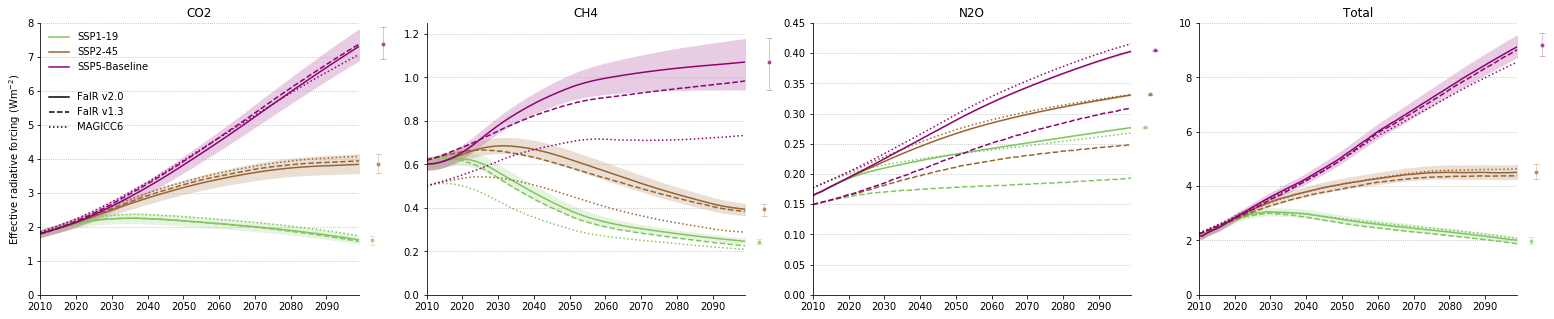

In [29]:
# gas forcings default
# total forcing
# Co2 concentrations

#### Full temperature range comparison:

plot_xlim = np.arange(2010,2100)

gs = matplotlib.gridspec.GridSpec(1, 51)
fig = plt.figure(figsize=(27,5))
ax = []
ax1 = []
ax += [plt.subplot(gs[0, :11])]
ax1 += [plt.subplot(gs[0, 11])]
ax += [plt.subplot(gs[0, 13:24])]
ax1 += [plt.subplot(gs[0, 24])]
ax += [plt.subplot(gs[0, 26:37])]
ax1 += [plt.subplot(gs[0, 37])]
ax += [plt.subplot(gs[0, 39:50])]
ax1 += [plt.subplot(gs[0, 50])]


scenarios_to_plot = np.array(['SSP1-19','SSP2-45','SSP5-Baseline'])

scenario_colors = cmaps['hawaii']((1/scenarios_to_plot.size)*np.arange(scenarios_to_plot.size))[::-1]
    
for i,scenario in enumerate(scenarios_to_plot):
    
    for ii,gas in enumerate(['CO2','CH4','N2O']):

        RF_to_plot = SSP_baseline_run['RF'].xs((scenario,gas),level=(0,3),axis=1).loc[2010:]

        _95 = RF_to_plot.quantile(0.95,axis=1)
        _05 = RF_to_plot.quantile(0.05,axis=1)

        ax[ii].fill_between(np.arange(2010,2101),_95,_05,color=scenario_colors[i],alpha=0.2,linewidth=0)

        ax[ii].plot(np.arange(2010,2101),RF_to_plot['median']['median'],color=scenario_colors[i],label=scenario)

        ax1[ii].plot([i,i],[_05.loc[2100],_95.loc[2100]],color=scenario_colors[i],linewidth=0.8,alpha=0.3)
        ax1[ii].plot([i,i],[_05.loc[2100],_95.loc[2100]],color=scenario_colors[i],marker='_',linewidth=0,alpha=0.3)
        ax1[ii].plot([i],[RF_to_plot['median']['median'].loc[2100]],color=scenario_colors[i],marker='o',linewidth=0,alpha=0.6,ms=3)

        FaIR_plot = IAMC_db.loc[(IAMC_db.Variable=='AR5 climate diagnostics|Forcing|'+gas+'|FAIR|MED')&(IAMC_db.Scenario==scenario)&(IAMC_db.Model=='IMAGE 3.0.1')].iloc[:,5:].apply(pd.to_numeric).T.set_index(np.arange(2000,2101)).loc[2010:].iloc[:,0]

        ax[ii].plot(np.arange(2010,2101),FaIR_plot,color=scenario_colors[i],label='',linestyle='--')

        MAGICC_plot = IAMC_db.loc[(IAMC_db.Variable=='AR5 climate diagnostics|Forcing|'+gas+'|MAGICC6|MED')&(IAMC_db.Scenario==scenario)&(IAMC_db.Model=='IMAGE 3.0.1')].iloc[:,5:].apply(pd.to_numeric).T.set_index(np.arange(2000,2101)).loc[2010:].iloc[:,0]

        ax[ii].plot(np.arange(2010,2101),MAGICC_plot,color=scenario_colors[i],label='',linestyle=':')
        

    RF_to_plot = SSP_baseline_run['RF'].xs((scenario,'Total'),level=(0,3),axis=1).loc[2010:]

    _95 = RF_to_plot.quantile(0.95,axis=1)
    _05 = RF_to_plot.quantile(0.05,axis=1)

    ax[3].fill_between(np.arange(2010,2101),_95,_05,color=scenario_colors[i],alpha=0.2,linewidth=0)

    ax[3].plot(np.arange(2010,2101),RF_to_plot['median']['median'],color=scenario_colors[i],label='')

    ax1[3].plot([i,i],[_05.loc[2100],_95.loc[2100]],color=scenario_colors[i],linewidth=0.8,alpha=0.3)
    ax1[3].plot([i,i],[_05.loc[2100],_95.loc[2100]],color=scenario_colors[i],marker='_',linewidth=0,alpha=0.3)
    ax1[3].plot([i],[RF_to_plot['median']['median'].loc[2100]],color=scenario_colors[i],marker='o',linewidth=0,alpha=0.6,ms=3)

    FaIR_plot = IAMC_db.loc[(IAMC_db.Variable=='AR5 climate diagnostics|Forcing|FAIR|MED')&(IAMC_db.Scenario==scenario)&(IAMC_db.Model=='IMAGE 3.0.1')].iloc[:,5:].apply(pd.to_numeric).T.set_index(np.arange(2000,2101)).loc[2010:].iloc[:,0]

    ax[3].plot(np.arange(2010,2101),FaIR_plot,color=scenario_colors[i],label='',linestyle='--')

    MAGICC_plot = IAMC_db.loc[(IAMC_db.Variable=='AR5 climate diagnostics|Forcing|MAGICC6|MED')&(IAMC_db.Scenario==scenario)&(IAMC_db.Model=='IMAGE 3.0.1')].iloc[:,5:].apply(pd.to_numeric).T.set_index(np.arange(2000,2101)).loc[2010:].iloc[:,0]

    ax[3].plot(np.arange(2010,2101),MAGICC_plot,color=scenario_colors[i],label='',linestyle=':')
        
ax[0].plot([],[],alpha=0,label=' ')
ax[0].plot([],[],'k-',label='FaIR v2.0')
ax[0].plot([],[],'k--',label='FaIR v1.3')
ax[0].plot([],[],'k:',label='MAGICC6')
        
axes_ymax = [8,1.25,0.45,10]
    
for i,axes in enumerate(ax):
    axes.set_xlim(plot_xlim.min(),plot_xlim.max())
    axes.spines['right'].set_visible(False)
    axes.spines['top'].set_visible(False)
    axes.grid(axis='y',linestyle=':',zorder=0)
    axes.set_ylim(0,axes_ymax[i])
    axes.set_title(['CO2','CH4','N2O','Total'][i])
    
for i,axes in enumerate(ax1):
    axes.set_ylim(0,axes_ymax[i])
    axes.axis('off')
    axes.set_xlim(-1,3)
    
# for axes in ax[1:]:
#     axes.set_yticklabels([])

fig.subplots_adjust(wspace=0.4)
    
# Make the legend

ax[0].set_ylabel('Effective radiative forcing (Wm$^{-2}$)')
ax[0].legend(frameon=False,loc='upper left')

# fig.savefig('./Final_figures/FaIRv2 v13 MAGICC comparison harmonized SSP default gas forcing response.svg',bbox_inches='tight')

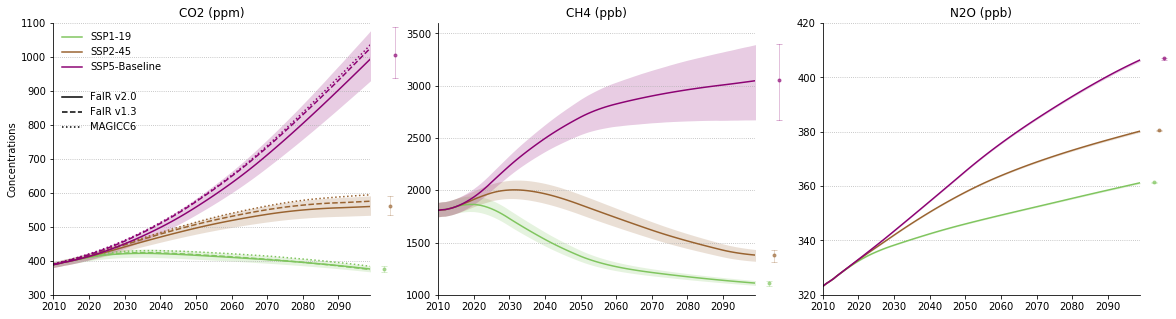

In [30]:
# gas forcings default
# total forcing
# Co2 concentrations

#### Full temperature range comparison:

plot_xlim = np.arange(2010,2100)

gs = matplotlib.gridspec.GridSpec(1, 38)
fig = plt.figure(figsize=(20,5))
ax = []
ax1 = []
ax += [plt.subplot(gs[0, :11])]
ax1 += [plt.subplot(gs[0, 11])]
ax += [plt.subplot(gs[0, 13:24])]
ax1 += [plt.subplot(gs[0, 24])]
ax += [plt.subplot(gs[0, 26:37])]
ax1 += [plt.subplot(gs[0, 37])]

scenarios_to_plot = np.array(['SSP1-19','SSP2-45','SSP5-Baseline'])

scenario_colors = cmaps['hawaii']((1/scenarios_to_plot.size)*np.arange(scenarios_to_plot.size))[::-1]
    
for i,scenario in enumerate(scenarios_to_plot):
    
    for ii,gas in enumerate(['CO2','CH4','N2O']):

        conc_to_plot = SSP_baseline_run['C'].xs((scenario,gas),level=(0,3),axis=1).loc[2010:]

        _95 = conc_to_plot.quantile(0.95,axis=1)
        _05 = conc_to_plot.quantile(0.05,axis=1)

        ax[ii].fill_between(np.arange(2010,2101),_95,_05,color=scenario_colors[i],alpha=0.2,linewidth=0)

        ax[ii].plot(np.arange(2010,2101),conc_to_plot['median']['median'],color=scenario_colors[i],label=scenario)

        ax1[ii].plot([i,i],[_05.loc[2100],_95.loc[2100]],color=scenario_colors[i],linewidth=0.8,alpha=0.3)
        ax1[ii].plot([i,i],[_05.loc[2100],_95.loc[2100]],color=scenario_colors[i],marker='_',linewidth=0,alpha=0.3)
        ax1[ii].plot([i],[conc_to_plot['median']['median'].loc[2100]],color=scenario_colors[i],marker='o',linewidth=0,alpha=0.6,ms=3)

        if gas == 'CO2':
        
            FaIR_plot = IAMC_db.loc[(IAMC_db.Variable=='AR5 climate diagnostics|Concentration|'+gas+'|FAIR|MED')&(IAMC_db.Scenario==scenario)&(IAMC_db.Model=='IMAGE 3.0.1')].iloc[:,5:].apply(pd.to_numeric).T.set_index(np.arange(2000,2101)).loc[2010:].iloc[:,0]

            ax[ii].plot(np.arange(2010,2101),FaIR_plot,color=scenario_colors[i],label='',linestyle='--')

            MAGICC_plot = IAMC_db.loc[(IAMC_db.Variable=='AR5 climate diagnostics|Concentration|'+gas+'|MAGICC6|MED')&(IAMC_db.Scenario==scenario)&(IAMC_db.Model=='IMAGE 3.0.1')].iloc[:,5:].apply(pd.to_numeric).T.set_index(np.arange(2000,2101)).loc[2010:].iloc[:,0]

            ax[ii].plot(np.arange(2010,2101),MAGICC_plot,color=scenario_colors[i],label='',linestyle=':')
        
ax[0].plot([],[],alpha=0,label=' ')
ax[0].plot([],[],'k-',label='FaIR v2.0')
ax[0].plot([],[],'k--',label='FaIR v1.3')
ax[0].plot([],[],'k:',label='MAGICC6')
        
axes_ymax = [1100,3600,420]
axes_ymin = [300,1000,320]
    
for i,axes in enumerate(ax):
    axes.set_xlim(plot_xlim.min(),plot_xlim.max())
    axes.spines['right'].set_visible(False)
    axes.spines['top'].set_visible(False)
    axes.grid(axis='y',linestyle=':',zorder=0)
    axes.set_ylim(axes_ymin[i],axes_ymax[i])
    axes.set_title(['CO2 (ppm)','CH4 (ppb)','N2O (ppb)'][i])
    
for i,axes in enumerate(ax1):
    axes.set_ylim(axes_ymin[i],axes_ymax[i])
    axes.axis('off')
    axes.set_xlim(-1,3)
    
# for axes in ax[1:]:
#     axes.set_yticklabels([])

fig.subplots_adjust(wspace=0.4)
    
# Make the legend

ax[0].set_ylabel('Concentrations')
ax[0].legend(frameon=False,loc='upper left')

# fig.savefig('./Final_figures/FaIRv2 v13 MAGICC comparison harmonized SSP default gas concentrations.svg',bbox_inches='tight')

## Some unit tests - iIRF100, AGWPs (pulse experiments)

In [9]:
## Get emissions compatible with the concentrations to 2018 then fixed after. Other forcings fixed after 

Fix_concs_2018_run = pd.concat([CMIP6_concs_extended.copy().reindex(np.concatenate((np.arange(1750,2018),np.arange(2018,2121,0.1)))).fillna(CMIP6_concs_extended.iloc[-1,:])],keys=['Fix_concs'],axis=1)

Fix_concs_2018_run_forc = pd.concat([other_forc_observed.copy().reindex(np.concatenate((np.arange(1750,2018),np.arange(2018,2121,0.1)))).fillna(other_forc_observed.iloc[-1,0])],keys=['Fix_concs'],axis=1)

# Fix_concs_2018_run = pd.concat([CMIP6_concs_extended.copy().reindex(np.arange(1750,2150)).fillna(CMIP6_concs_extended.iloc[-1,:])],keys=['Fix_concs'],axis=1)

# Fix_concs_2018_run_forc = pd.concat([other_forc_observed.copy().reindex(np.arange(1750,2150)).fillna(other_forc_observed.iloc[-1,0])],keys=['Fix_concs'],axis=1)

Fix_concs_future_emms = run_UnFaIR(concentrations_in=Fix_concs_2018_run,forcing_in=Fix_concs_2018_run_forc,gas_parameters=TUNED_gas_cycle_params,thermal_parameters=tcr_ecs_to_q(TUNED_thermal_params),show_run_info=False)['Emissions']

In [10]:
def run_pulse_experiment(pulse_sizes):

    Pulse_experiments = [Fix_concs_future_emms.droplevel((0,1,2),1).copy()]
    
    index_2019 = Fix_concs_future_emms.droplevel((0,1,2),1).copy().index[np.argmin(abs(Fix_concs_future_emms.droplevel((0,1,2),1).copy().index-2019))]

    for gas in ['CO2','CH4','N2O']:

        add_pulse = Pulse_experiments[0].copy()

        add_pulse.loc[index_2019,gas] = add_pulse.loc[index_2019,gas] + pulse_sizes[gas]

        Pulse_experiments += [add_pulse]

    Pulse_experiment_emissions = pd.concat(Pulse_experiments,keys=['Base','1MtCO2','1MtCH4','1MtN2O'],axis=1)

    Pulse_experiment_results = run_UnFaIR(emissions_in=Pulse_experiment_emissions,forcing_in=Fix_concs_2018_run_forc,gas_parameters=gas_cycle_param_set,thermal_parameters=tcr_ecs_to_q(thermal_param_set),show_run_info=False)
    
    return Pulse_experiment_results

In [11]:
def diagnose_gas_cycle_pulse_properties(pulse_size):

    default_pulse_size = {'CO2':12/44000,'CH4':1,'N2O':28/44}

    Pulse_experiment_results = run_pulse_experiment(pulse_size)

    GWP_scalings = {'CO2':1,'CH4':1.65,'N2O':(1-0.36*(1.65)*0.363/3)}
    
    index_2119 = Pulse_experiment_results['RF'].index[abs(Pulse_experiment_results['RF'].index-2119).argmin()]
    index_2039 = Pulse_experiment_results['RF'].index[abs(Pulse_experiment_results['RF'].index-2039).argmin()]
    
    timestep_sizes = np.append(np.diff(Pulse_experiment_results['C'].index),np.diff(Pulse_experiment_results['C'].index)[-1])[:,np.newaxis]
    
    AGWP_diagnosed_100_CO2 = (((Pulse_experiment_results['RF'].xs(('CO2'),level=(3),axis=1)['1Mt'+'CO2'] - Pulse_experiment_results['RF'].xs(('CO2'),level=(3),axis=1)['Base'])).cumsum()*timestep_sizes).loc[index_2119].values * 10**(-9) * 10**(13) * default_pulse_size['CO2'] / pulse_size['CO2']
    AGWP_diagnosed_20_CO2 = (((Pulse_experiment_results['RF'].xs(('CO2'),level=(3),axis=1)['1Mt'+'CO2'] - Pulse_experiment_results['RF'].xs(('CO2'),level=(3),axis=1)['Base'])).cumsum()*timestep_sizes).loc[index_2039].values * 10**(-9) * 10**(13) * default_pulse_size['CO2'] / pulse_size['CO2']

    for gas in ['CO2','CH4','N2O']:

        scaling = default_gas_forcing_params().loc['emis2conc',('default',gas)]*pulse_size[gas]

        iIRF100_diagnosed = (((Pulse_experiment_results['C'].xs((gas),level=(3),axis=1)['1Mt'+gas] - Pulse_experiment_results['C'].xs((gas),level=(3),axis=1)['Base'])/scaling).cumsum()*timestep_sizes).loc[index_2119].values
        AF_diagnosed = ((Pulse_experiment_results['C'].xs((gas),level=(3),axis=1)['1Mt'+gas] - Pulse_experiment_results['C'].xs((gas),level=(3),axis=1)['Base'])/scaling).loc[index_2119].values

        AGWP_diagnosed_100 = (((Pulse_experiment_results['RF'].xs((gas),level=(3),axis=1)['1Mt'+gas] - Pulse_experiment_results['RF'].xs((gas),level=(3),axis=1)['Base'])).cumsum()*timestep_sizes).loc[index_2119].values * 10**(-9) * 10**(13) * default_pulse_size[gas] / pulse_size[gas]
        AGWP_diagnosed_20 = (((Pulse_experiment_results['RF'].xs((gas),level=(3),axis=1)['1Mt'+gas] - Pulse_experiment_results['RF'].xs((gas),level=(3),axis=1)['Base'])).cumsum()*timestep_sizes).loc[index_2039].values * 10**(-9) * 10**(13) * default_pulse_size[gas] / pulse_size[gas]
        
        IPT = (Pulse_experiment_results['T']['1Mt'+gas] - Pulse_experiment_results['T']['Base']).loc[:2050].idxmax()

        print(gas)
        print('iIRF100:',np.median(iIRF100_diagnosed),'[',np.percentile(iIRF100_diagnosed,16),np.percentile(iIRF100_diagnosed,84),']')
        print('Instantaneous airbourne fraction:',np.median(AF_diagnosed),'[',np.percentile(AF_diagnosed,16),np.percentile(AF_diagnosed,84),']')
        print('AGWP100:',np.median(AGWP_diagnosed_100),'[',np.percentile(AGWP_diagnosed_100,16),np.percentile(AGWP_diagnosed_100,84),']')
        print('AGWP20:',np.median(AGWP_diagnosed_20),'[',np.percentile(AGWP_diagnosed_20,16),np.percentile(AGWP_diagnosed_20,84),']')
        print('GWP100:',np.median(AGWP_diagnosed_100/AGWP_diagnosed_100_CO2),'[',np.percentile(AGWP_diagnosed_100/AGWP_diagnosed_100_CO2,16),np.percentile(AGWP_diagnosed_100/AGWP_diagnosed_100_CO2,84),']')
        print('GWP100_full:',GWP_scalings[gas]*np.median(AGWP_diagnosed_100/AGWP_diagnosed_100_CO2),'[',GWP_scalings[gas]*np.percentile(AGWP_diagnosed_100/AGWP_diagnosed_100_CO2,16),GWP_scalings[gas]*np.percentile(AGWP_diagnosed_100/AGWP_diagnosed_100_CO2,84),']')
        print('GWP20:',np.median(AGWP_diagnosed_20/AGWP_diagnosed_20_CO2),'[',np.percentile(AGWP_diagnosed_20/AGWP_diagnosed_20_CO2,16),np.percentile(AGWP_diagnosed_20/AGWP_diagnosed_20_CO2,84),']')
        print('GWP20_full:',GWP_scalings[gas]*np.median(AGWP_diagnosed_20/AGWP_diagnosed_20_CO2),'[',GWP_scalings[gas]*np.percentile(AGWP_diagnosed_20/AGWP_diagnosed_20_CO2,16),GWP_scalings[gas]*np.percentile(AGWP_diagnosed_20/AGWP_diagnosed_20_CO2,84),']')
        print('IPT:',np.median(IPT)-2019,'[',np.percentile(IPT,16)-2019,np.percentile(IPT,84)-2019,']')
        print()
        
    return Pulse_experiment_results

Pulse_experiment_results = diagnose_gas_cycle_pulse_properties({'CO2':12/44000,'CH4':1,'N2O':28/44})

CO2
iIRF100: 49.0543613291808 [ 46.66699493630834 51.72508425922649 ]
Instantaneous airbourne fraction: 0.4216037473072949 [ 0.4013034353898274 0.4447361277080806 ]
AGWP100: 0.841665618302468 [ 0.8115665654295592 0.8761896598648481 ]
AGWP20: 0.21791801181872017 [ 0.21125222793722973 0.22441619836619092 ]
GWP100: 1.0 [ 1.0 1.0 ]
GWP100_full: 1.0 [ 1.0 1.0 ]
GWP20: 1.0 [ 1.0 1.0 ]
GWP20_full: 1.0 [ 1.0 1.0 ]
IPT: 11.299999999988813 [ 10.799999999989268 12.099999999988086 ]

CH4
iIRF100: 11.719294809288353 [ 10.900025363630487 12.758195741227638 ]
Instantaneous airbourne fraction: -0.00013070692699762424 [ -0.00037214263826350667 5.408736003313179e-05 ]
AGWP100: 18.120241273231816 [ 17.099560774491724 19.308443778552927 ]
AGWP20: 14.911699451472067 [ 14.449296070030982 15.371915247368392 ]
GWP100: 21.613594505976337 [ 19.880324975613398 23.24420814204705 ]
GWP100_full: 35.66243093486096 [ 32.8025362097621 38.35294343437763 ]
GWP20: 68.61350835826157 [ 65.20392458888996 71.75767570587698 ]

Note that the result seems independent of the pulse size until reaching the point where the lifetime feedbacks and conc->forcing relations break down.

### Calculating the TCRE

In [54]:
## FULL TCRE
print('Effective TCRE:')
for RCP in ['45','6','85']:
    Threshold_years = abs((RCP_concentration_driven_results['Emissions'].xs((RCP,'CO2'),level=(0,3),axis=1) - RCP_concentration_driven_results['Emissions'].xs((RCP,'CO2'),level=(0,3),axis=1).loc[1870].mean()).cumsum()-1000).idxmin()
    TCRE_vals = np.zeros(100*100)
    RCP_T = (RCP_concentration_driven_results['T'][RCP] - RCP_concentration_driven_results['T'][RCP].loc[1861:1880].mean())
    for i in np.arange(TCRE_vals.size):
        TCRE_vals[i] = RCP_T.loc[Threshold_years.iloc[i],Threshold_years.index[i]]
    print(RCP,':',np.median(TCRE_vals),'[',np.percentile(TCRE_vals,5),np.percentile(TCRE_vals,95),']')

Effective TCRE:
45 : 1.9594091097577673 [ 1.1940986915574072 3.7009441888559924 ]
6 : 1.9244380339769516 [ 1.160523129332453 3.5847771407932005 ]
85 : 2.0573445774694674 [ 1.269930758141767 3.8700792009441423 ]


In [48]:
## CO2-only TCRE

RCP_CO2_only_concentration_run = RCP_concentration_run.copy()
RCP_CO2_only_concentration_run.loc[:,(slice(None),['CH4','N2O'])] = 1e-12

RCP_CO2_only_conc_driven = run_UnFaIR(concentrations_in=RCP_CO2_only_concentration_run,forcing_in=return_empty_forcing(RCP_CO2_only_concentration_run),\
                                  gas_parameters=gas_cycle_param_set,thermal_parameters=tcr_ecs_to_q(thermal_param_set))

Integrating 4 scenarios, 100 gas cycle parameter sets, 100 thermal response parameter sets, over ['CO2', 'CH4', 'N2O'], between 1765 and 2200...


In [55]:
print('CO2-only TCRE:')
for RCP in ['45','6','85']:
    Threshold_years = abs((RCP_CO2_only_conc_driven['Emissions'].xs((RCP,'CO2'),level=(0,3),axis=1) - RCP_CO2_only_conc_driven['Emissions'].xs((RCP,'CO2'),level=(0,3),axis=1).loc[1870].mean()).cumsum()-1000).idxmin()
    TCRE_vals = np.zeros(100*100)
    RCP_T = (RCP_CO2_only_conc_driven['T'][RCP] - RCP_CO2_only_conc_driven['T'][RCP].loc[1861:1880].mean())
    for i in np.arange(TCRE_vals.size):
        TCRE_vals[i] = RCP_T.loc[Threshold_years.iloc[i],Threshold_years.index[i]]
    print(RCP,':',np.median(TCRE_vals),'[',np.percentile(TCRE_vals,5),np.percentile(TCRE_vals,95),']')

CO2-only TCRE:
45 : 1.4214409895760913 [ 0.9001054997250915 2.5784045805496385 ]
6 : 1.4067884641965815 [ 0.8915099374852119 2.536319173574306 ]
85 : 1.3897736372374645 [ 0.8903060460973456 2.507672277379421 ]


In [52]:
# Generate some parameter ensembles uncertainties:

N = 499

# TCR ~ lognorm ; RWF ~ norm
TCR_samples = np.random.lognormal(np.log(2.5)/2,np.log(2.5)/(2*1.645),N)
RWF_samples = np.random.normal(0.6,0.15/1.645,N)
ECS_samples = TCR_samples/RWF_samples

# Put the distributions into a format readable by FaIR
thermal_param_template = default_thermal_params().default
thermal_param_template.loc['tcr_ecs'] = [np.sqrt(2.5),2.66]
thermal_param_list = [thermal_param_template]
for i in np.arange(N):    
    thermal_param_curr = thermal_param_template.copy()
    thermal_param_curr.loc['tcr_ecs'] = [TCR_samples[i],ECS_samples[i]]
    thermal_param_list += [thermal_param_curr]    
thermal_param_set_abrupt = pd.concat(thermal_param_list,keys=['median']+['set'+str(x) for x in np.arange(N)],axis=1)

# Generate a gas cycle parameter set based on normally distributed parameters
gas_cycle_param_set_abrupt = draw_monte_carlo_param_set(400,TUNED_gas_cycle_params,TUNED_gas_cycle_param_uncertainties)

## 4xCO2 experiment

abrupt_4x_CO2_exp = return_empty_emissions(start_year=0,end_year=200,scen_names=['Abrupt4xCO2']) + default_gas_forcing_params().loc['PI_conc','default'].values
abrupt_4x_CO2_exp.loc[:,('Abrupt4xCO2','CO2')] = abrupt_4x_CO2_exp.loc[0,('Abrupt4xCO2','CO2')]*1.01**(abrupt_4x_CO2_exp.index)

abrupt_4x_CO2_exp_results = run_UnFaIR(concentrations_in=abrupt_4x_CO2_exp,forcing_in=return_empty_forcing(abrupt_4x_CO2_exp),\
                                  gas_parameters=gas_cycle_param_set_abrupt,thermal_parameters=tcr_ecs_to_q(thermal_param_set_abrupt))

Integrating 1 scenarios, 400 gas cycle parameter sets, 500 thermal response parameter sets, over ['CO2', 'CH4', 'N2O'], between 0.0 and 200.0...


In [53]:
onepctexp_TCRE = 1000*(abrupt_4x_CO2_exp_results['T'].loc[70]/abrupt_4x_CO2_exp_results['Emissions'].xs('CO2',level=-1,axis=1).cumsum().loc[70])
print('1% exp TCRE:',np.median(onepctexp_TCRE),'[',np.percentile(onepctexp_TCRE,5),np.percentile(onepctexp_TCRE,95),']')

1% exp TCRE: 1.3306866725372468 [ 0.8472739783557138 2.1566307199271004 ]


# BREAK

# CMIP6 social cost of carbon calculation

### import the CMIP6 thermal parameters from J. Tsutsui

In [ ]:
## Do I do some IAMC scenarios with GenIR tuned to different CMIP6 models now - to show only one model really necessary given it is sufficiently tunable?? ##

JT_params = pd.read_csv('./J_Tsutsui_params/2019-07-17_1954/parms_cmip6_20190716.csv')

JT_params = JT_params.loc[(JT_params.iloc[:,1] == 'tas')&((JT_params.iloc[:,2] == 'irm-2')|(JT_params.iloc[:,2] == 'irm-3'))]

JT_UnFaIR_params = pd.DataFrame(columns=[1,2,3],index=['d','q'])

JT_UnFaIR_params.index = JT_UnFaIR_params.index.rename('param_name')

JT_UnFaIR_params.columns = JT_UnFaIR_params.columns.rename('Box')

param_list = []

for i in JT_params.index:

    curr_params = JT_UnFaIR_params.copy()
    
    curr_params.loc['d'] = (JT_params.loc[i,'tau0':'tau2']).values
    
    curr_params.loc['q'] = (JT_params.loc[i,'a0':'a2'] / JT_params.loc[i,'lambda']).values
    
    param_list += [curr_params]
    
JT_UnFaIR_params = pd.concat(param_list, keys = JT_params.iloc[:,0]+'_'+JT_params.iloc[:,2], axis = 1)

JT_UnFaIR_params.columns = JT_UnFaIR_params.columns.rename(['CMIP6-model_IR(n)','Box'])

JT_UnFaIR_params = JT_UnFaIR_params.apply(pd.to_numeric)

JT_UnFaIR_params.loc['d',([x for x in JT_UnFaIR_params.columns.levels[0] if 'irm-2' in x],3)] = 1.
JT_UnFaIR_params.loc['q',([x for x in JT_UnFaIR_params.columns.levels[0] if 'irm-2' in x],3)] = 0

### FaIR v2 f parameters tuned to CMIP6 (via J. Tsutsui approximation)

In [ ]:
### calculate the f-parameters 

## tuning forcing response parameters to Tsutsui et al ##

JT_params.index = JT_params.iloc[:,0] +'_'+ JT_params.iloc[:,2]

def JT_co2_forcing(*args, **kwargs):

    """

    Return effective radiative forcing values for a given sequence of

    CO2 concentrations

 

    Parameters

    ----------

    ccref : float, default 278 ppm

        Reference CO2 concentration

 

    alpha : float, default 5.35 W/m2

        Scaling factor

 

    beta : float, default 1.

        Amplification factor at the second doubling

    """

    ccref = kwargs.get('ccref', 278.)

    alpha = kwargs.get('alpha', 5.35)

    beta = kwargs.get('beta', 1.)

    rf = alpha * np.log( np.hstack(args) / ccref )

    if beta != 1:

        rf2x = alpha * np.log(2.)

        ix = rf > rf2x

        rf[ix] = (beta-1.)*(rf[ix]-2.*rf2x)*(2./rf2x*rf[ix]-1.)+beta*rf[ix]

    return rf.squeeze()

def GenIR_forcing(conc,f,include_sqrt=False):
    return f[0] * np.log( conc/278 ) + f[1] * ( conc - 278 ) + include_sqrt * f[2] * ( np.sqrt(conc) - np.sqrt(278) )

def fit_to_1000ppm(f,CMIP6_model):
    conc_range = np.arange(278,1000)
    JT = JT_co2_forcing(conc_range,beta=JT_params.loc[CMIP6_model,'beta'],alpha=JT_params.loc[CMIP6_model,'alpha'])
    GenIR = GenIR_forcing(conc_range,f,True)
    return np.sum((GenIR-JT)**2)
    
fig,ax = plt.subplots(3,6,figsize=(20,10))
axes=ax.flatten()
    
for i,CMIP6_model in enumerate([x for x in JT_params.index if 'irm-3' in x]):
    
    conc_range = np.arange(278,1000)
    
    f = sp.optimize.minimize(fit_to_1000ppm,[5.35,0,0],args=CMIP6_model,method='Nelder-mead').x
    
    axes[i].plot(conc_range,JT_co2_forcing(conc_range,beta=JT_params.loc[CMIP6_model,'beta'],alpha=JT_params.loc[CMIP6_model,'alpha']),'k:',label='Tsutsui (2017)',linewidth=2.5)
    axes[i].plot(conc_range,GenIR_forcing(conc_range,f,True),'b',label='FaIR v2',zorder=0,linewidth=2.5)
    axes[i].set_title(CMIP6_model[:-6])
    axes[i].set_ylim(0,7.5)
    axes[i].set_xlim(278,1000)
    
for axes in ax[:2].flatten():
    axes.set_xticklabels('')
for axes in ax[:,1:].flatten():
    axes.set_yticklabels('')
for axes in ax[:,0].flatten():
    axes.set_ylabel('Radiative forcing (Wm$^{-2}$)')
for axes in ax[-1,:].flatten():
    axes.set_xlabel('CO$_2$ concentration (ppm)')
    
ax[0,0].legend(loc='upper left')
ax[-1,-1].set_visible(False)
fig.subplots_adjust(wspace=0.1,hspace=0.2)

In [ ]:
f_params_CMIP6 = pd.DataFrame(index=['f1','f2','f3'],columns=JT_params.index)
for CMIP6_model in JT_params.index:
    f = sp.optimize.minimize(fit_to_1000ppm,[5.35,0,0],args=CMIP6_model,method='Nelder-mead').x
    f_params_CMIP6.loc['f1':'f3',CMIP6_model] = f
    
f_params_CMIP6.apply(pd.to_numeric).to_pickle('./Parameter_Sets/CMIP6_f_parameters.p')

### set up the emission scenario (ssp245)

In [ ]:
SSP245_emissions = IAMC_db.loc[(IAMC_db.Variable.isin(['Diagnostics|MAGICC6|Harmonized Input|Emissions|'+x for x in ['CH4','N2O','CO2|AFOLU','CO2|Energy and Industrial Processes']]))&(IAMC_db.Scenario=='SSP2-45')&(IAMC_db.Model=='MESSAGE-GLOBIOM 1.0')]

SSP245_emissions = SSP245_emissions.iloc[:,5:].apply(pd.to_numeric).interpolate(axis=1)#.set_index(['CH4','CO2-AFOLU','CO2-EIP','N2O'])
SSP245_emissions.index = ['CH4','CO2-AFOLU','CO2-EIP','N2O']
SSP245_emissions.loc['CO2'] = SSP245_emissions.loc[['CO2-AFOLU','CO2-EIP']].sum()
SSP245_emissions = SSP245_emissions.T[['CO2','CH4','N2O']]
SSP245_emissions = (SSP245_emissions * [12/44000,1,28/44000]).dropna().set_index(np.arange(2005,2101))

#### harmonize the emissions to observationally consistent values (from RCP8.5 inversion)

In [ ]:
# harmonization method: use a linearly variable scaling factor applied to the SSP scenario with the maximum value in 2005 and 1 by 2025

RCP85_historical_diagnosed_emms = RCP_concentration_driven_results['Emissions']['85']['median']['median']

b, a = signal.butter(1, 0.05)
for gas in ['CO2','CH4','N2O']:
    RCP85_historical_diagnosed_emms[gas] = signal.filtfilt(b, a, RCP85_historical_diagnosed_emms[gas])

RCP85_SSP245_join = pd.concat([RCP85_historical_diagnosed_emms.loc[:2004],SSP245_emissions])

for gas in ['CO2','CH4','N2O']:
    RCP85_SSP245_join.loc[2005:2025,gas] = RCP85_SSP245_join.loc[2005:2025,gas] * np.linspace(RCP85_historical_diagnosed_emms.loc[2005,gas]/RCP85_SSP245_join.loc[2005,gas],1,21)

emms_units = {'CO2':'GtC','CH4':'MtCH4','N2O':'MtN2O-N2'}

fig,ax = plt.subplots(1,3,figsize=(15,5))

for i,gas in enumerate(['CO2','CH4','N2O']):
    SSP245_emissions[gas].plot(ax=ax[i],color='k',label='SSP245')
    RCP85_SSP245_join.loc[SSP245_emissions.index,gas].plot(ax=ax[i],color='b',label='SSP245-harmonized')
    ax[i].set_title(gas)
    ax[i].set_ylabel('Emission rate ('+emms_units[gas]+' yr$^{-1}$)')
ax[0].legend(frameon=False,loc='lower left')
plt.tight_layout()

#### grab and harmonize the other-forcing scenario (RCP85 history, SSP245 total minus CO2 CH4 N2O)

In [ ]:
SSP245_forcings = IAMC_db.loc[(IAMC_db.Variable.isin(['AR5 climate diagnostics|Forcing'+x+'|MAGICC6|MED' for x in ['|CH4','|N2O','|CO2','']]))&(IAMC_db.Scenario=='SSP2-45')&(IAMC_db.Model=='MESSAGE-GLOBIOM 1.0')]
SSP245_forcings= SSP245_forcings.iloc[:,5:].apply(pd.to_numeric)
SSP245_forcings.index = ['CH4','CO2','Total','N2O']
SSP245_forcings = SSP245_forcings.T
SSP245_forcings['forcing'] = SSP245_forcings['Total'] - SSP245_forcings[['CO2','CH4','N2O']].sum(axis=1)
SSP245_forcings = SSP245_forcings.set_index(np.arange(2000,2101))

In [ ]:
harmonize_year = 2006
RCP85_SSP245_forcings_harmonized = RCP_other_forcings_run['85'].reindex(np.arange(1765,2101))
RCP85_SSP245_forcings_harmonized.loc[harmonize_year:2025,'forcing'] = SSP245_forcings.loc[harmonize_year:2025,'forcing'] * np.linspace(RCP85_SSP245_forcings_harmonized.loc[harmonize_year,'forcing']/SSP245_forcings.loc[harmonize_year,'forcing'],1,2025-harmonize_year+1)
RCP85_SSP245_forcings_harmonized.loc[2025:,'forcing'] = SSP245_forcings.loc[2025:,'forcing']

fig,ax = plt.subplots(figsize=(8,5))

SSP245_forcings['forcing'].plot(ax=ax,color='k',label='SSP245')
RCP85_SSP245_forcings_harmonized.loc[SSP245_forcings.index,'forcing'].plot(ax=ax,color='b',label='SSP245-harmonized')
ax.set_title('Other radiative forcings')
ax.set_ylabel('Forcing (Wm$^{-2}$)')
ax.legend(frameon=False,loc='lower right')
plt.tight_layout()

Note that the RCP forcing series has a large dip just after 2000 from a combination of the solar cycle and ? a volcanic eruption ?

In [ ]:
SSP245_GDP = IAMC_db.loc[(IAMC_db.Variable.isin(['GDP|MER','GDP|PPP']))&(IAMC_db.Scenario=='SSP2-45')&(IAMC_db.Model=='MESSAGE-GLOBIOM 1.0')].iloc[:,5:]
SSP245_GDP.index = ['GDP']
SSP245_GDP = SSP245_GDP.T.apply(pd.to_numeric).interpolate().set_index(np.arange(2000,2101)).dropna()
SSP245_GDP.plot()
plt.ylabel('billion US$2010')
plt.title('SSP245 GDP projections (MESSAGE-GLOBIOM 1.0)')

In [ ]:
### Create a function that takes a temperature dataframe and returns welfare equivalent consumption

def temp_to_WEC(temps):
    
    ## model can be DICE (quadratic) or WEITZ (see Weitzman 2012, quadratice plus higher order term)
    ## temperatures must be set relative to the desired baseline
    
    WEC_weitz = 1/( 1 + (temps/20.46)**2 + (temps/6.081)**6.754 )
    
    WEC_DICE = 1/( 1 + (temps/20.46)**2 )
    
    return pd.concat([WEC_weitz,WEC_DICE],keys=['WEITZ','DICE'],axis=1)

In [ ]:
def run_FaIR_scenario_CMIP6_model(cmip6_model,scenario,IAM='MESSAGE-GLOBIOM 1.0'):
    
    # get emissions from IAMC database
    
    scenario_emissions = IAMC_db.loc[(IAMC_db.Variable.isin(['Diagnostics|MAGICC6|Harmonized Input|Emissions|'+x for x in ['CH4','N2O','CO2|AFOLU','CO2|Energy and Industrial Processes']]))&(IAMC_db.Scenario==scenario)&(IAMC_db.Model==IAM)]
    scenario_emissions = scenario_emissions.iloc[:,5:].apply(pd.to_numeric).interpolate(axis=1)#.set_index(['CH4','CO2-AFOLU','CO2-EIP','N2O'])
    scenario_emissions.index = ['CH4','CO2-AFOLU','CO2-EIP','N2O']
    scenario_emissions.loc['CO2'] = scenario_emissions.loc[['CO2-AFOLU','CO2-EIP']].sum()
    scenario_emissions = scenario_emissions.T[['CO2','CH4','N2O']]
    scenario_emissions = (scenario_emissions * [12/44000,1,28/44000]).dropna().set_index(np.arange(2005,2101))
    
    # harmonize emissions to inverted RCP85 concentrations
    
    RCP85_historical_diagnosed_emms = RCP_concentration_driven_results['Emissions']['85']['median']['median']

    b, a = signal.butter(1, 0.05)
    for gas in ['CO2','CH4','N2O']:
        RCP85_historical_diagnosed_emms[gas] = signal.filtfilt(b, a, RCP85_historical_diagnosed_emms[gas])

    RCP85_scenario_emissions_harmonized = pd.concat([RCP85_historical_diagnosed_emms.loc[:2004],scenario_emissions])

    for gas in ['CO2','CH4','N2O']:
        RCP85_scenario_emissions_harmonized.loc[2005:2025,gas] = RCP85_scenario_emissions_harmonized.loc[2005:2025,gas] * np.linspace(RCP85_historical_diagnosed_emms.loc[2005,gas]/RCP85_scenario_emissions_harmonized.loc[2005,gas],1,21)
        
    # include the required 1Mt pulse experiments:
    
    SCC_emms_list = [RCP85_scenario_emissions_harmonized]

    gas_unit_scaling = {'CO2':1e-9*12/44,'CH4':1e-6,'N2O':1e-6*28/44}

    for gas in ['CO2','CH4','N2O']:
        scenario_1Gt_pulse_2019 = RCP85_scenario_emissions_harmonized.copy()
        scenario_1Gt_pulse_2019.loc[2019,gas] = scenario_1Gt_pulse_2019.loc[2019,gas] + 1000000 * gas_unit_scaling[gas]
        SCC_emms_list += [scenario_1Gt_pulse_2019]

    scenario_emms_SCC = pd.concat(SCC_emms_list,keys=['Baseline','1MtCO2','1MtCH4','1MtN2O'],axis=1)
        
    # get forcings from IAMC database
    
    scenario_forcings = IAMC_db.loc[(IAMC_db.Variable.isin(['AR5 climate diagnostics|Forcing'+x+'|MAGICC6|MED' for x in ['|CH4','|N2O','|CO2','']]))&(IAMC_db.Scenario=='SSP2-45')&(IAMC_db.Model=='MESSAGE-GLOBIOM 1.0')]
    scenario_forcings= scenario_forcings.iloc[:,5:].apply(pd.to_numeric)
    scenario_forcings.index = ['CH4','CO2','Total','N2O']
    scenario_forcings = scenario_forcings.T
    scenario_forcings['forcing'] = scenario_forcings['Total'] - scenario_forcings[['CO2','CH4','N2O']].sum(axis=1)
    scenario_forcings = scenario_forcings.set_index(np.arange(2000,2101))
    
    # harmonize forcings to RCP85 forcings
    
    harmonize_year = 2006
    RCP85_scenario_forcings_harmonized = RCP_other_forcings_run['85'].reindex(np.arange(1765,2101))
    RCP85_scenario_forcings_harmonized.loc[harmonize_year:2025,'forcing'] = scenario_forcings.loc[harmonize_year:2025,'forcing'] * np.linspace(RCP85_scenario_forcings_harmonized.loc[harmonize_year,'forcing']/scenario_forcings.loc[harmonize_year,'forcing'],1,2025-harmonize_year+1)
    RCP85_scenario_forcings_harmonized.loc[2025:,'forcing'] = scenario_forcings.loc[2025:,'forcing']
    
    scenario_forcings_SCC = return_empty_forcing(scenario_emms_SCC) + RCP85_scenario_forcings_harmonized.values

    # run the model
    
    run_thermal_params = pd.concat([JT_UnFaIR_params[cmip6_model]],keys=[cmip6_model],axis=1)
    run_gas_params = TUNED_gas_cycle_params.copy()
    run_gas_params.loc['f1':'f3',('default','CO2')] = f_params_CMIP6[cmip6_model].apply(pd.to_numeric)
    FaIR_run = run_UnFaIR(emissions_in=scenario_emms_SCC,forcing_in=scenario_forcings_SCC,gas_parameters=run_gas_params,thermal_parameters=run_thermal_params,show_run_info=False)['T'].droplevel(1,1)
    
    return FaIR_run

In [ ]:
def calculate_SCC_WEC(cmip6_model,scenario,IAM='MESSAGE-GLOBIOM 1.0',discounting=3):
    
    FaIR_temps = run_FaIR_scenario_CMIP6_model(cmip6_model,scenario,IAM)
    
    # Get the GDP projections:
    
    scenario_GDP = IAMC_db.loc[(IAMC_db.Variable== 'GDP|PPP')&(IAMC_db.Scenario==scenario)&(IAMC_db.Model==IAM)].iloc[:,5:]
    scenario_GDP.index = ['GDP']
    scenario_GDP = scenario_GDP.T.apply(pd.to_numeric).interpolate().set_index(np.arange(2000,2101)).dropna()
    scenario_GDP = scenario_GDP * 136477 / scenario_GDP.loc[2018] # scale to worldbank present-day value
    
    # calculate the WEC:
    
    WEC = temp_to_WEC(FaIR_temps)
    
    # calculate the GDP timeseries for each experiment including climate damages
    
    GDP_damaged = WEC.loc[scenario_GDP.index] * scenario_GDP.values
    
    # calculate the GDP loss relative to baseline scenario
    
    GDP_loss = GDP_damaged - GDP_damaged.xs('Baseline',level=1,axis=1)
    
    # discount at the specified rate:
    
    discounted_GDP_loss = GDP_loss.loc[2019:] * np.exp(-(discounting/100)*(GDP_loss.loc[2019:].index.values[:,np.newaxis]-2019))
    
    # scale to convert SCC to be in units of 2018 US$ per tonne and sum over the 21st century
    
    social_cost = (discounted_GDP_loss.sum(axis=0)*1e9/1e6)
    
    return social_cost, WEC, FaIR_temps

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(18,5))
fig1,ax1 = plt.subplots(1,3,figsize=(18,5))

model_colors = plt.cm.tab10(np.arange(3)*0.5)

## MIROC6 : lowest
## CNRM-ESM2-1 : middle
## UKESM1-0-LL : highest
## [x for x in JT_UnFaIR_params.columns.levels[0] if 'irm-3' in x] : all

for i,model in enumerate([x + '_irm-3' for x in ['MIROC6','CNRM-ESM2-1','UKESM1-0-LL']]):
    
    SCC_SSP245_3,WEC_SSP245_3,temps_SSP245_3 = calculate_SCC_WEC(model,'SSP2-45',IAM='MESSAGE-GLOBIOM 1.0',discounting=3)
    SCC_SSP2base_3,WEC_SSP2base_3,temps_SSPbase_3 = calculate_SCC_WEC(model,'SSP2-Baseline',IAM='MESSAGE-GLOBIOM 1.0',discounting=3)
    SCC_SSP245_0,WEC_SSP245_0,temps_SSP245_0 = calculate_SCC_WEC(model,'SSP2-45',IAM='MESSAGE-GLOBIOM 1.0',discounting=0)
    
    for ii,exp in enumerate(['1MtCO2','1MtCH4','1MtN2O']):
    
        ax[ii].plot(i,-1*SCC_SSP245_3.loc['DICE',model,exp],'o',color=model_colors[i],label=model[:-6])
        ax[ii].plot(i,-1*SCC_SSP245_3.loc['WEITZ',model,exp],'o',color=model_colors[i],label='',mfc='none')
        ax[ii].plot(i,-1*SCC_SSP2base_3.loc['DICE',model,exp],'v',color=model_colors[i],label='')
        ax[ii].plot(i,-1*SCC_SSP245_0.loc['DICE',model,exp],'^',color=model_colors[i],label='')
        
        ax1[ii].plot((100*1e-6*(WEC_SSP245_3 - WEC_SSP245_3.xs('Baseline',level=1,axis=1))).loc[2017:,('DICE',model,exp)],label=model[:-6],color=model_colors[i])
        
for i,gas in enumerate(['CO2','CH4','N2O']):
    
    ax[i].set_xlim(-0.5,2.5)
    ax[i].set_yscale('log')
    ax[i].set_title(gas)
    ax[i].set_xticks(np.arange(3))
    ax[i].set_xticklabels(['MIROC6','CNRM-ESM2-1','UKESM1-0-LL'])
    
    ax1[i].set_xlim(2017,2100)
    ax1[i].set_title(gas)
        
ax[0].set_ylabel('Cost (current price US$)')
    
# ax1[1].legend(bbox_to_anchor=(-1.2, -0.02, 3.38, -0.1),mode='expand', ncol=5,borderaxespad=0.,loc=2,frameon=False)
ax1[1].legend(frameon=False,loc='lower right')
ax1[0].set_ylabel('GDP change (%)')

fig.suptitle('Social cost in 2019 over the 21st century of a 1 tonne emission')
fig1.suptitle('Welfare-equivalent consumption change over the 21st century')


fig.savefig('Social cost of three major GHGs.png',bbox_inches='tight')
fig1.savefig('Welfare-equivalent consumption to 2100 of GHGs.png',bbox_inches='tight')

## The impact of an additional timescale on the Social cost of CO2

In [ ]:
CMIP6_tuned_models = list(set([x[:-6] for x in JT_UnFaIR_params.columns.levels[0]]))

SCC_values = pd.DataFrame(index=CMIP6_tuned_models,columns=['2 box','3 box'])

for CMIP6_model in CMIP6_tuned_models:

    SCC_values.loc[CMIP6_model,'2 box'] = calculate_SCC_WEC(CMIP6_model+'_irm-2','SSP2-45',IAM='MESSAGE-GLOBIOM 1.0',discounting=1.5)[0].loc['DICE',CMIP6_model+'_irm-2','1MtCO2']
    SCC_values.loc[CMIP6_model,'3 box'] = calculate_SCC_WEC(CMIP6_model+'_irm-3','SSP2-45',IAM='MESSAGE-GLOBIOM 1.0',discounting=1.5)[0].loc['DICE',CMIP6_model+'_irm-3','1MtCO2']

In [ ]:
SCC_values

In [ ]:
fig,ax = plt.subplots(figsize=(10,5))

test_SCC_2box = calculate_SCC_WEC('UKESM1-0-LL'+'_irm-2','SSP2-45',IAM='MESSAGE-GLOBIOM 1.0',discounting=10)[2]
test_SCC_2box = test_SCC_2box.xs('1MtCO2',level=0,axis=1) - test_SCC_2box.xs('Baseline',level=0,axis=1)
test_SCC_2box.plot(ax=ax,color='b')

test_SCC_2box = calculate_SCC_WEC('UKESM1-0-LL'+'_irm-3','SSP2-45',IAM='MESSAGE-GLOBIOM 1.0',discounting=10)[2]
test_SCC_2box = test_SCC_2box.xs('1MtCO2',level=0,axis=1) - test_SCC_2box.xs('Baseline',level=0,axis=1)
test_SCC_2box.plot(ax=ax,color='r')

plt.xlim(2000,2100)

plt.savefig('SCC response UKESM1 vs baseline.png')

## All extra bits

#### Numeric vs analytic alpha

In [ ]:
## Figure showing the comparison of the numerical vs analytic solution of the iIRF100:

gas_parameters = default_gas_forcing_params()

a = gas_parameters.loc['a1':'a4',('default','CO2')].values[np.newaxis,:]

tau = gas_parameters.loc['tau1':'tau4',('default','CO2')].values[np.newaxis,:]

def FaIR_alpha(alpha,iIRF,a,tau):
    
    return (iIRF - np.sum(a*alpha[:,np.newaxis]*tau*(1-np.exp(-100/(alpha[:,np.newaxis]*tau))),axis=-1))**2

def GenIR_alpha(iIRF,a,tau):
    
    g1 = np.sum( a * tau * ( 1. - ( 1. + 100/tau ) * np.exp(-100/tau) ), axis=-1 )
    g0 = ( np.sinh( np.sum( a * tau * ( 1. - np.exp(-100/tau) ) , axis=-1) / g1 ) )**(-1.)
    
    return g0 * np.sinh( iIRF / g1 )

def GenIR_iIRF(alpha,a,tau):
    
    g1 = np.sum( a * tau * ( 1. - ( 1. + 100/tau ) * np.exp(-100/tau) ), axis=-1 )
    g0 = ( np.sinh( np.sum( a * tau * ( 1. - np.exp(-100/tau) ) , axis=-1) / g1 ) )**(-1.)
    
    return g1*np.arcsinh(alpha/g0)

iIRF_calc = np.arange(25,98)

FaIR_calc = sp.optimize.root(FaIR_alpha,np.full(98-25,1),args=(iIRF_calc,a,tau),method='lm').x

GenIR_calc = GenIR_alpha(iIRF_calc,a,tau)

plt.semilogy(iIRF_calc,FaIR_calc,'r--',label='FaIR v1.3 (numeric)')
plt.semilogy(iIRF_calc,GenIR_calc,'b',label='FaIR v2.0 (analytic)')
plt.xlabel('iIRF$_{100}$ value')
plt.ylabel(r'computed $\alpha$')
plt.legend()
plt.xlim(iIRF_calc[0],iIRF_calc[-1])

plt.savefig('./Final_figures/iIRF100_numeric_analytic.svg',bbox_inches='tight')

plt.figure()

plt.plot(iIRF_calc,GenIR_calc/FaIR_calc,'k')
plt.axhline(1,color='grey',linestyle='--',zorder=0,linewidth=1)
plt.title(r'fractional calculated $\alpha$')
plt.xlabel('iIRF$_{100}$ value')
plt.ylabel(r'$\alpha_{GenIR}$/$\alpha_{FaIR}$')
plt.xlim(iIRF_calc[0],iIRF_calc[-1])

#### Some variable timescale experiments

In [59]:
template_1 = return_empty_emissions(start_year=0,end_year=100,scen_names=['1'],timestep=1)['1']

experiments = []
experiment_names = []

for gas in ['CO2','N2O','CH4']:

    curr_1 = template_1.copy()
    curr_1.loc[10,gas] = 1

    experiments += [curr_1]
    experiment_names += ['1pulse'+gas]

    curr_1 = template_1.copy()
    curr_1.loc[10:50,gas] = 1

    experiments += [curr_1]
    experiment_names += ['1sustain'+gas]

emissions_1 = pd.concat(experiments,keys=experiment_names,axis=1)

In [64]:
template_1 = pd.DataFrame(columns=['CO2','CH4','N2O'],index=np.arange(0,100,0.1))

experiments = []
experiment_names = []

for gas in ['CO2','N2O','CH4']:

    curr_1 = template_1.copy()
    curr_1.loc[10,gas] = 1

    experiments += [curr_1]
    experiment_names += ['1pulse'+gas]

    curr_1 = template_1.copy()
    curr_1.loc[10:50,gas] = 1/10

    experiments += [curr_1]
    experiment_names += ['1sustain'+gas]

emissions_01 = pd.concat(experiments,keys=experiment_names,axis=1).fillna(0)

In [82]:
template_1 = pd.DataFrame(columns=['CO2','CH4','N2O'],index=np.concatenate((np.arange(0,10,1),np.arange(10,100,0.1))))

experiments = []
experiment_names = []

for gas in ['CO2','N2O','CH4']:

    curr_1 = template_1.copy()
    curr_1.loc[10,gas] = 1

    experiments += [curr_1]
    experiment_names += ['1pulse'+gas]

    curr_1 = template_1.copy()
    curr_1.loc[10:50,gas] = 1/10

    experiments += [curr_1]
    experiment_names += ['1sustain'+gas]

emissions_var = pd.concat(experiments,keys=experiment_names,axis=1).fillna(0)

In [83]:
timestep_1 = run_UnFaIR(emissions_in=emissions_1)
timestep_01 = run_UnFaIR(emissions_in=emissions_01)
timestep_var = run_UnFaIR(emissions_in=emissions_var)

Integrating 6 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['CO2', 'CH4', 'N2O'], between 0.0 and 100.0...
Integrating 6 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['CO2', 'CH4', 'N2O'], between 0.0 and 99.9...
Integrating 6 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['CO2', 'CH4', 'N2O'], between 0.0 and 99.89999999999968...


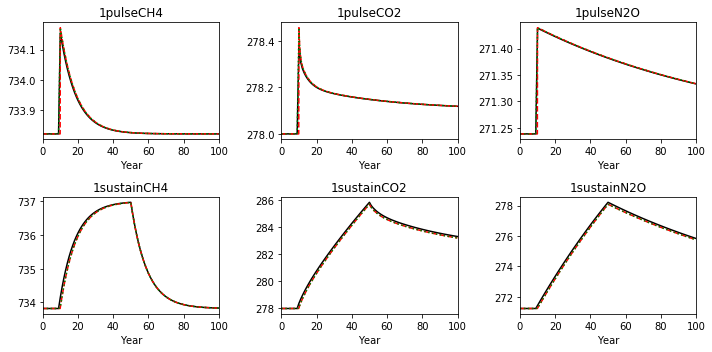

In [87]:
fig,ax=plt.subplots(2,3,figsize=(10,5))

for i,exp in enumerate(timestep_1['C'].columns.levels[0]):

    timestep_1['C'][exp]['default']['default'][exp[-3:]].plot(ax=ax.flatten()[i],color='k')
    timestep_01['C'][exp]['default']['default'][exp[-3:]].plot(ax=ax.flatten()[i],color='r',linestyle='--')
    timestep_var['C'][exp]['default']['default'][exp[-3:]].plot(ax=ax.flatten()[i],color='g',linestyle=':')
    ax.flatten()[i].set_title(exp)
    
plt.tight_layout()